In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgbm
from sklearn.model_selection import KFold,GroupKFold
from catboost import CatBoostRegressor,Pool
from lightgbm import LGBMRegressor

from sklearn.metrics import mean_squared_log_error

import optuna 

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
df_test = test.copy()
df_train = train.copy()

submission = pd.read_csv('sample_submission.csv')
price = pd.read_csv('price.csv')

tasit = pd.read_csv('tasitsayisi.csv')
tufe = pd.read_csv('tufe.csv')
brent = pd.read_csv('Brent Petrol Vadeli İşlemleri Geçmiş Verileri.csv')
usd = pd.read_csv('USD_TRY Geçmiş Verileri.csv')
gini = pd.read_csv('gini_set.csv')


In [3]:
df_train["Billing Date"] = pd.to_datetime(train["Billing Date"])
df_test["Week Start Date"] = pd.to_datetime(test["Week Start Date"])

price["Validfrom"] = pd.to_datetime(price["Validfrom"])
tufe["date"] = pd.to_datetime(tufe["date"])

usd["Tarih"] = pd.to_datetime(usd["Tarih"])
brent["Tarih"] = pd.to_datetime(brent["Tarih"])

df_train["year"] = df_train["Billing Date"].dt.year
df_train["month"] = df_train["Billing Date"].dt.month
df_train["week"] = df_train["Billing Date"].dt.weekofyear

df_test["year"] = df_test["Week Start Date"].dt.year
df_test["month"] = df_test["Week Start Date"].dt.month
df_test["week"] = df_test["Week Start Date"].dt.weekofyear

price["year"] = price["Validfrom"].dt.year
price["month"] = price["Validfrom"].dt.month
price["week"] = price["Validfrom"].dt.weekofyear

tufe["year"] = tufe["date"].dt.year
tufe["month"] = tufe["date"].dt.month


usd["year"] = usd["Tarih"].dt.year
usd["month"] = usd["Tarih"].dt.month
usd["week"] = usd["Tarih"].dt.weekofyear

brent["year"] = brent["Tarih"].dt.year
brent["month"] = brent["Tarih"].dt.month
brent["week"] = brent["Tarih"].dt.weekofyear

In [4]:
price = price.groupby(["City Code","year","week","Product"])["CRP"].agg(["mean","std","max","min"]).reset_index()

price.columns = ["City Code","year","week","Product","CRP_mean","CRP_std","CRP_max","CRP_min"]

In [5]:
usd.drop(["Açılış","Yüksek","Düşük","Hac.","Fark %","Düşük"],axis=1,inplace=True)

usd["Şimdi"] = usd["Şimdi"].apply(lambda x: x.replace(",",".")).astype(float)

brent["Şimdi"] = brent["Şimdi"].apply(lambda x: x.replace(",",".")).astype(float)



In [6]:
usd.head()

,Tarih,Şimdi,year,month,week
0,2019-12-31,5.9479,2019,12,1
1,2019-12-30,5.9441,2019,12,1
2,2019-12-27,5.9492,2019,12,52
3,2019-12-26,5.9286,2019,12,52
4,2019-12-25,5.9340,2019,12,52


In [7]:
usd = usd.groupby(["year","week"])["Şimdi"].agg(["mean","std","max","min"]).reset_index()

usd.columns = ["year","week","USD_mean","USD_std","USD_max","USD_min"]

brent = brent.groupby(["year","week"])["Şimdi"].agg(["mean","std","max","min"]).reset_index()

brent.columns = ["year","week","Brent_mean","Brent_std","Brent_max","Brent_min"]


In [8]:
il_bölge = {"Antalya":"Akdeniz Bölgesi",
            "Burdur":"Akdeniz Bölgesi",
            "Isparta":"Akdeniz Bölgesi",
            "Mersin":"Akdeniz Bölgesi",
            "Adana":"Akdeniz Bölgesi",
            "Hatay":"Akdeniz Bölgesi",
            "Osmaniye":"Akdeniz Bölgesi",
            "K.Maraş":"Akdeniz Bölgesi",
            "İzmir":"Ege Bölgesi",
            "Aydın":"Ege Bölgesi",
            "Muğla":"Ege Bölgesi",
            "Manisa":"Ege Bölgesi",
            "Denizli":"Ege Bölgesi",
            "Uşak":"Ege Bölgesi",
            "Kütahya":"Ege Bölgesi",
            "Afyonkarahisar":"Ege Bölgesi",
            "Gaziantep":"Güneydoğu Anadolu Bölgesi",
            "Kilis":"Güneydoğu Anadolu Bölgesi",
            "Adıyaman":"Güneydoğu Anadolu Bölgesi",
            "Ş.Urfa":"Güneydoğu Anadolu Bölgesi",
            "Diyarbakır":"Güneydoğu Anadolu Bölgesi",
            "Mardin":"Güneydoğu Anadolu Bölgesi",
            "Batman":"Güneydoğu Anadolu Bölgesi",
            "Siirt":"Güneydoğu Anadolu Bölgesi",
            "Bolu":"Karadeniz Bölgesi",
            "Düzce":"Karadeniz Bölgesi",
            "Zonguldak":"Karadeniz Bölgesi",
            "Karabük":"Karadeniz Bölgesi",
            "Bartın":"Karadeniz Bölgesi",
            "Kastamonu":"Karadeniz Bölgesi",
            "Çorum":"Karadeniz Bölgesi",
            "Sinop":"Karadeniz Bölgesi",
            "Samsun":"Karadeniz Bölgesi",
            "Amasya":"Karadeniz Bölgesi",
            "Tokat":"Karadeniz Bölgesi",
            "Ordu":"Karadeniz Bölgesi",
            "Giresun":"Karadeniz Bölgesi",
            "Gümüşhane":"Karadeniz Bölgesi",
            "Trabzon":"Karadeniz Bölgesi",
            "Bayburt":"Karadeniz Bölgesi",
            "Rize":"Karadeniz Bölgesi",
            "Artvin":"Karadeniz Bölgesi",
            "Çanakkale":"Marmara Bölgesi",
            "Balıkesir":"Marmara Bölgesi",
            "Edirne":"Marmara Bölgesi",
            "Tekirdağ":"Marmara Bölgesi",
            "Kırklareli":"Marmara Bölgesi",
            "İstanbul":"Marmara Bölgesi",
            "Bursa":"Marmara Bölgesi",
            "Yalova":"Marmara Bölgesi",
            "Kocaeli":"Marmara Bölgesi",
            "Sakarya":"Marmara Bölgesi",
            "Bilecik":"Marmara Bölgesi",
            "Eskişehir":"İç Anadolu Bölgesi",
            "Konya":"İç Anadolu Bölgesi",
            "Ankara":"İç Anadolu Bölgesi",
            "Çankırı":"İç Anadolu Bölgesi",
            "Aksaray":"İç Anadolu Bölgesi",
            "Kırıkkale":"İç Anadolu Bölgesi",
            "Kırşehir":"İç Anadolu Bölgesi",
            "Yozgat":"İç Anadolu Bölgesi",
            "Niğde":"İç Anadolu Bölgesi",
            "Nevşehir":"İç Anadolu Bölgesi",
            "Kayseri":"İç Anadolu Bölgesi",
            "Karaman":"İç Anadolu Bölgesi",
            "Sivas":"İç Anadolu Bölgesi",
            "Malatya":"Doğu Anadolu Bölgesi",
            "Erzincan":"Doğu Anadolu Bölgesi",
            "Elazığ":"Doğu Anadolu Bölgesi",
            "Tunceli":"Doğu Anadolu Bölgesi",
            "Bingöl":"Doğu Anadolu Bölgesi",
            "Erzurum":"Doğu Anadolu Bölgesi",
            "Muş":"Doğu Anadolu Bölgesi",
            "Bitlis":"Doğu Anadolu Bölgesi",
            "Şırnak":"Doğu Anadolu Bölgesi",
            "Kars":"Doğu Anadolu Bölgesi",
            "Ağrı":"Doğu Anadolu Bölgesi",
            "Ardahan":"Doğu Anadolu Bölgesi",
            "Van":"Doğu Anadolu Bölgesi",
            "Iğdır":"Doğu Anadolu Bölgesi",
            "Hakkari":"Doğu Anadolu Bölgesi"}

In [9]:
# giniye bölge ismini ekliyoruz
gini["bölge"] = gini["il"].map(il_bölge)


In [10]:
# otomobil,minibus,otobüs,kamyon ve kamyonet strip

tasit["otomobil"] = tasit["otomobil"].astype(str).str.replace(' ', '')
tasit["minibus"] = tasit["minibus"].astype(str).str.replace(' ', '')
tasit["otobus"] = tasit["otobus"].astype(str).str.replace(' ', '')
tasit["kamyon"] = tasit["kamyon"].astype(str).str.replace(' ', '')
tasit["kamyonet"] = tasit["kamyonet"].astype(str).str.replace(' ', '')

In [11]:
tasit["otomobil"] = tasit["otomobil"].astype(float)
tasit["minibus"] = tasit["minibus"].astype(float)
tasit["otobus"] = tasit["otobus"].astype(float)
tasit["kamyon"] = tasit["kamyon"].astype(float)
tasit["kamyonet"] = tasit["kamyonet"].astype(float)

In [12]:
tasit = tasit.groupby(["year","bölge"]).agg({"otomobil":"sum",
                    "minibus":"sum",
                    "otobus":"sum",
                    "kamyonet":"sum",
                    "kamyon":"sum"}).reset_index()

In [13]:
# citylerin haftalık litrelerinin toplamı ile date_list'i birleştiriyoruz

df_train = df_train.groupby(["City Code", "week","month","year","Customer","Product"])["Litres"].sum().reset_index()

df_train.head()

,City Code,week,month,year,Customer,Product,Litres
0,116,1,1,2014,12122988,Benzin,0.0
1,116,1,1,2014,12122988,Motorin,0.0
2,116,1,1,2015,12122988,Benzin,5242.0
3,116,1,1,2015,12122988,Motorin,26162.0
4,116,1,1,2016,12122988,Benzin,3521.0


In [14]:
df_train.shape

(533021, 7)

In [15]:
# price ile df_train birleştiriyoruz
df_train = pd.merge(df_train, price, on=["City Code","year","week","Product"],how="left")
df_test = pd.merge(df_test, price, on=["City Code","year","week","Product"],how="left")
df_train.head()

,City Code,week,month,year,Customer,Product,Litres,CRP_mean,CRP_std,CRP_max,CRP_min
0,116,1,1,2014,12122988,Benzin,0.0,NaN,NaN,NaN,NaN
1,116,1,1,2014,12122988,Motorin,0.0,NaN,NaN,NaN,NaN
2,116,1,1,2015,12122988,Benzin,5242.0,NaN,NaN,NaN,NaN
3,116,1,1,2015,12122988,Motorin,26162.0,NaN,NaN,NaN,NaN
4,116,1,1,2016,12122988,Benzin,3521.0,NaN,NaN,NaN,NaN


In [16]:
df_train.shape

(533021, 11)

In [17]:
city_area = train.groupby(["City Code","Area"])["Litres"].sum().reset_index()
city_area.drop("Litres", axis=1, inplace=True)
city_area.head()

,City Code,Area
0,116,Doğu Anadolu Bölgesi
1,125,Karadeniz Bölgesi
2,126,Marmara Bölgesi
3,150,Güneydoğu Anadolu Bölgesi
4,172,Güneydoğu Anadolu Bölgesi


In [18]:
# df_train ile city_area area'ları birleştiriyoruz
df_train = pd.merge(df_train, city_area, how='left', on=['City Code'])

In [19]:
df_train.shape, df_test.shape

((533021, 12), (108472, 13))

In [20]:
df_train.head()

,City Code,week,month,year,Customer,Product,Litres,CRP_mean,CRP_std,CRP_max,CRP_min,Area
0,116,1,1,2014,12122988,Benzin,0.0,NaN,NaN,NaN,NaN,Doğu Anadolu Bölgesi
1,116,1,1,2014,12122988,Motorin,0.0,NaN,NaN,NaN,NaN,Doğu Anadolu Bölgesi
2,116,1,1,2015,12122988,Benzin,5242.0,NaN,NaN,NaN,NaN,Doğu Anadolu Bölgesi
3,116,1,1,2015,12122988,Motorin,26162.0,NaN,NaN,NaN,NaN,Doğu Anadolu Bölgesi
4,116,1,1,2016,12122988,Benzin,3521.0,NaN,NaN,NaN,NaN,Doğu Anadolu Bölgesi


In [21]:
df_train = pd.merge(df_train, 
                tasit, how='left', left_on=['year',"Area"], right_on=['year',"bölge"])

df_train.drop("bölge", axis=1, inplace=True)
                
df_test = pd.merge(df_test, 
                tasit, how='left', left_on=['year',"Area"], right_on=['year',"bölge"])

df_test.drop("bölge", axis=1, inplace=True)

In [22]:
df_train.shape, df_test.shape

((533021, 17), (108472, 18))

In [23]:
# tufe ile df_train ve df_test birleştirme
df_train = pd.merge(df_train, tufe, how='left', left_on=['year',"month"], right_on=['year',"month"])
df_train.drop("date", axis=1, inplace=True)

df_test = pd.merge(df_test, tufe, how='left', left_on=['year',"month"], right_on=['year',"month"])
df_test.drop("date", axis=1, inplace=True)

In [24]:
df_train.shape, df_test.shape

((533021, 19), (108472, 20))

In [25]:
df_train  = pd.merge(df_train, usd, how='left', on=['year',"week"])
df_test  = pd.merge(df_test, usd, how='left', on=['year',"week"])

In [26]:
# brent ile df_train ve df_test birleştirme
df_train = pd.merge(df_train, brent, how='left', on=['year',"week"])
df_test = pd.merge(df_test, brent, how='left', on=['year',"week"])

In [27]:
num_cols = ["CRP_mean","CRP_std","CRP_max","CRP_min","otomobil","minibus","otobus","kamyonet","kamyon","tufe yillik degisim orani","tufe aylik degisim orani",
            "USD_mean","USD_std","USD_max","USD_min","Brent_mean","Brent_std","Brent_max","Brent_min"]

In [28]:
df_train.isna().sum()

City Code                       0
week                            0
month                           0
year                            0
Customer                        0
Product                         0
Litres                          0
CRP_mean                     3010
CRP_std                      3012
CRP_max                      3010
CRP_min                      3010
Area                            0
otomobil                        0
minibus                         0
otobus                          0
kamyonet                        0
kamyon                          0
tufe yillik degisim orani       0
tufe aylik degisim orani        0
USD_mean                        0
USD_std                         0
USD_max                         0
USD_min                         0
Brent_mean                      0
Brent_std                    1670
Brent_max                       0
Brent_min                       0
dtype: int64

In [29]:
df_test.isna().sum()

index                          0
Customer                       0
Area                           0
City Code                      0
Product                        0
Week Start Date                0
year                           0
month                          0
week                           0
CRP_mean                     104
CRP_std                      104
CRP_max                      104
CRP_min                      104
otomobil                       0
minibus                        0
otobus                         0
kamyonet                       0
kamyon                         0
tufe yillik degisim orani      0
tufe aylik degisim orani       0
USD_mean                       0
USD_std                        0
USD_max                        0
USD_min                        0
Brent_mean                     0
Brent_std                      0
Brent_max                      0
Brent_min                      0
dtype: int64

In [30]:
train_mis_cols = ["CRP_mean","CRP_std","CRP_max","CRP_min","Brent_std"]
test_mis_cols = ["CRP_mean","CRP_std","CRP_max","CRP_min"]

# city_code kırılımında eksik değerleri mean ile dolduruyoruz
for col in train_mis_cols:
    df_train[col] = df_train.groupby("City Code")[col].transform(lambda x: x.fillna(x.mean()))

for col in test_mis_cols:
    df_test[col] = df_test.groupby("City Code")[col].transform(lambda x: x.fillna(x.mean()))

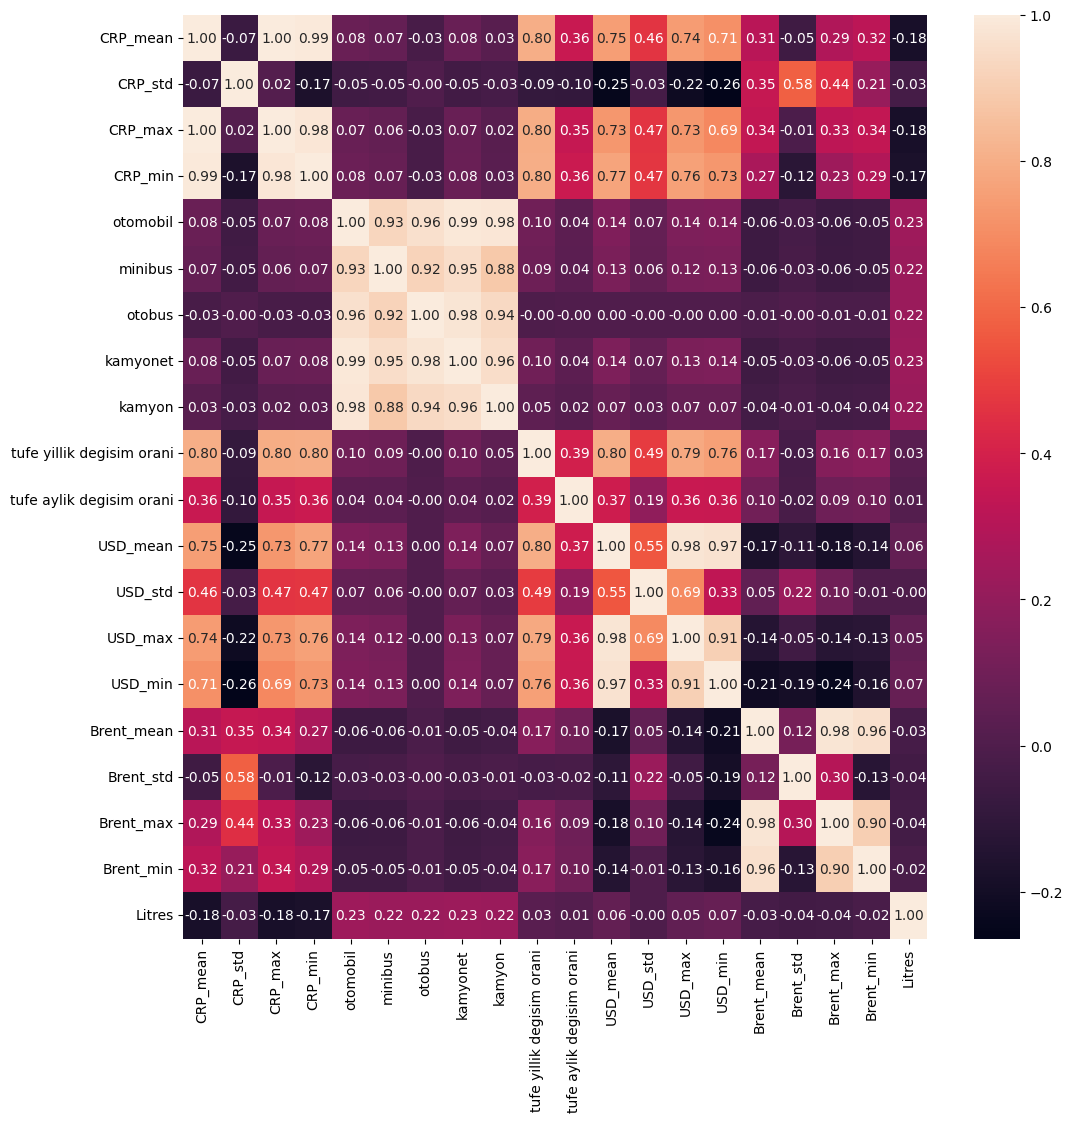

In [31]:
# pearson correlation matrix
num_cols.append("Litres")
cor = df_train[num_cols].corr(method="pearson",).abs()
upper = cor.where(np.triu(np.ones(cor.shape), k=1).astype(np.bool_))
to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

# heatmap
plt.figure(figsize=(12,12))
sns.heatmap(df_train[num_cols].corr(), annot=True, fmt=".2f")   
plt.show()


In [32]:
to_drop

['CRP_max',
 'CRP_min',
 'minibus',
 'otobus',
 'kamyonet',
 'kamyon',
 'USD_max',
 'USD_min',
 'Brent_max',
 'Brent_min']

In [33]:
num_cols = [col for col in num_cols if col not in to_drop]

cat_cols = ["City Code","Product","Area","week"]

useful_cols = num_cols + cat_cols

# df_train_copy = df_train.copy()
# df_test_copy = df_test.copy()

df_train_copy = df_train[useful_cols]
useful_cols.remove("Litres")
df_test_copy = df_test[useful_cols]

# # frequency encoding
# for col in cat_cols:
#     df_train_copy[col] = df_train[col].map(df_train[col].value_counts())
#     df_test_copy[col] = df_test[col].map(df_test[col].value_counts())

In [34]:
group = df_train.Customer

X = df_train_copy.drop(labels = ["Litres"], axis=1)
y = df_train_copy["Litres"]



features = X.columns
#df_test = df_test[features]

for caterogical_col in cat_cols:
    X[cat_cols] = X[cat_cols].astype(str).astype("category")
    df_test[cat_cols] = df_test[cat_cols].astype(str).astype("category")

In [35]:
gkf = GroupKFold(n_splits=10)

In [36]:
# LGBM regressor optuna
import gc
from optuna.integration import LightGBMPruningCallback

gc.collect()



def objective_lgbm(trial):
    param = {
        "objective": "regression",
        "metric": "rmse",
        "verbosity": -1,
        'seed':1,
        "boosting_type": trial.suggest_categorical("boosting_type", ["gbdt", "gbrt"]),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "max_depth": trial.suggest_int("max_depth", 5, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 0, 100),
        "max_bin": trial.suggest_int("max_bin", 10, 1000),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "min_split_gain": trial.suggest_float("min_split_gain", 1e-8, 1.0, log=True),
        "feature_fraction" : trial.suggest_float("feature_fraction", 0.4, 1.0),
    }
    
    score_rmsle_lgbm = []
    for train_index, test_index in gkf.split(X, y, group):
        X_train,X_val = X.iloc[train_index],X.iloc[test_index]
        y_train,y_val = y.iloc[train_index],y.iloc[test_index]
        
        calback = LightGBMPruningCallback(trial, "rmse")
        model = LGBMRegressor(**param)
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)],eval_metric="rmse",
                     early_stopping_rounds=100, verbose=100, 
                     callbacks=[calback],categorical_feature=cat_cols)

        y_pred = model.predict(X_val)
        y_pred = np.where(y_pred < 0, 0, y_pred)
        score = np.sqrt(mean_squared_log_error(y_val, y_pred))
        score_rmsle_lgbm.append(score)

    return np.mean(score_rmsle_lgbm)

In [37]:
# catboost optuna
from optuna.integration import CatBoostPruningCallback

def objective_cat(trial):
    param = {
        "objective": "RMSE",
        "eval_metric": "RMSE",
        "boosting_type": "Plain",
        "random_seed": 1,
        "loss_function":'RMSE',
        "allow_writing_files":False,
        "random_seed":42,
        "cat_features":cat_cols,
        "depth": trial.suggest_int("depth", 3, 10, step=1),
        "subsample": trial.suggest_float("subsample", 0.5, 0.99),
        'od_wait': trial.suggest_int('od_wait', 10, 50, step=1),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.5, 0.99),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 50.0),
        "n_estimators": trial.suggest_int("n_estimators", 100, 2500, step=1),
        'learning_rate': trial.suggest_loguniform("learning_rate", 0.005, 0.1)
    }
    
    score_rmsle_cat = []
    for train_index, test_index in gkf.split(X, y,groups=group):
        X_train,X_val = X.iloc[train_index],X.iloc[test_index]
        y_train,y_val = y.iloc[train_index],y.iloc[test_index]
        
        
        model = CatBoostRegressor(**param)
        pruning_callback = CatBoostPruningCallback(trial, "RMSE")
        model.fit(X_train, y_train, eval_set=[(X_val, y_val)],verbose=False,
                            early_stopping_rounds=100,
                            callbacks=[pruning_callback])

        y_pred = model.predict(X_val)
        y_pred = np.where(y_pred < 0, 0, y_pred)
        score = np.sqrt(mean_squared_log_error(y_val, y_pred))
        score_rmsle_cat.append(score)

    return np.mean(score_rmsle_cat)

In [38]:
study_lgbm = optuna.create_study(direction="minimize", study_name="lgbm",pruner=optuna.pruners.MedianPruner(n_warmup_steps=5, interval_steps=1, n_startup_trials=10))
study_lgbm.optimize(objective_lgbm, n_trials=100)

[I 2023-01-06 02:36:56,195] A new study created in memory with name: lgbm


[LightGBM] [Warning] feature_fraction is set=0.841624884436728, colsample_bytree=0.8554363019923992 will be ignored. Current value: feature_fraction=0.841624884436728
[100]	valid_0's rmse: 30260
[LightGBM] [Warning] feature_fraction is set=0.841624884436728, colsample_bytree=0.8554363019923992 will be ignored. Current value: feature_fraction=0.841624884436728
[100]	valid_0's rmse: 37889.5
[LightGBM] [Warning] feature_fraction is set=0.841624884436728, colsample_bytree=0.8554363019923992 will be ignored. Current value: feature_fraction=0.841624884436728
[100]	valid_0's rmse: 23427.7
[LightGBM] [Warning] feature_fraction is set=0.841624884436728, colsample_bytree=0.8554363019923992 will be ignored. Current value: feature_fraction=0.841624884436728
[100]	valid_0's rmse: 25840.1
[LightGBM] [Warning] feature_fraction is set=0.841624884436728, colsample_bytree=0.8554363019923992 will be ignored. Current value: feature_fraction=0.841624884436728
[100]	valid_0's rmse: 28601.6
[LightGBM] [Warni

[I 2023-01-06 02:37:23,938] Trial 0 finished with value: 1.9103042058095372 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.01351603199710553, 'num_leaves': 255, 'max_depth': 6, 'min_child_samples': 12, 'max_bin': 320, 'subsample': 0.8151996129450745, 'colsample_bytree': 0.8554363019923992, 'min_split_gain': 5.0895836882085115e-05, 'feature_fraction': 0.841624884436728}. Best is trial 0 with value: 1.9103042058095372.


[100]	valid_0's rmse: 30292.6
[LightGBM] [Warning] feature_fraction is set=0.5005619513059137, colsample_bytree=0.6806588429452268 will be ignored. Current value: feature_fraction=0.5005619513059137
[100]	valid_0's rmse: 28716.2
[LightGBM] [Warning] feature_fraction is set=0.5005619513059137, colsample_bytree=0.6806588429452268 will be ignored. Current value: feature_fraction=0.5005619513059137
[100]	valid_0's rmse: 35638.2
[LightGBM] [Warning] feature_fraction is set=0.5005619513059137, colsample_bytree=0.6806588429452268 will be ignored. Current value: feature_fraction=0.5005619513059137
[100]	valid_0's rmse: 21972.4
[LightGBM] [Warning] feature_fraction is set=0.5005619513059137, colsample_bytree=0.6806588429452268 will be ignored. Current value: feature_fraction=0.5005619513059137
[100]	valid_0's rmse: 23948.6
[LightGBM] [Warning] feature_fraction is set=0.5005619513059137, colsample_bytree=0.6806588429452268 will be ignored. Current value: feature_fraction=0.5005619513059137
[100]

[I 2023-01-06 02:37:58,008] Trial 1 finished with value: 1.806930116450983 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.032295767827535994, 'num_leaves': 165, 'max_depth': 9, 'min_child_samples': 43, 'max_bin': 549, 'subsample': 0.672295961436707, 'colsample_bytree': 0.6806588429452268, 'min_split_gain': 1.4869169878466528e-06, 'feature_fraction': 0.5005619513059137}. Best is trial 1 with value: 1.806930116450983.


[LightGBM] [Warning] feature_fraction is set=0.5445944823799505, colsample_bytree=0.5370166713725536 will be ignored. Current value: feature_fraction=0.5445944823799505
[100]	valid_0's rmse: 28832
[LightGBM] [Warning] feature_fraction is set=0.5445944823799505, colsample_bytree=0.5370166713725536 will be ignored. Current value: feature_fraction=0.5445944823799505
[100]	valid_0's rmse: 35156.5
[LightGBM] [Warning] feature_fraction is set=0.5445944823799505, colsample_bytree=0.5370166713725536 will be ignored. Current value: feature_fraction=0.5445944823799505
[100]	valid_0's rmse: 22039.5
[LightGBM] [Warning] feature_fraction is set=0.5445944823799505, colsample_bytree=0.5370166713725536 will be ignored. Current value: feature_fraction=0.5445944823799505
[100]	valid_0's rmse: 24066.3
[LightGBM] [Warning] feature_fraction is set=0.5445944823799505, colsample_bytree=0.5370166713725536 will be ignored. Current value: feature_fraction=0.5445944823799505
[100]	valid_0's rmse: 27069.8
[LightG

[I 2023-01-06 02:38:23,899] Trial 2 finished with value: 1.7666345849985887 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.08741113175334882, 'num_leaves': 178, 'max_depth': 6, 'min_child_samples': 32, 'max_bin': 979, 'subsample': 0.2029296484554166, 'colsample_bytree': 0.5370166713725536, 'min_split_gain': 3.949684178379657e-05, 'feature_fraction': 0.5445944823799505}. Best is trial 2 with value: 1.7666345849985887.


[100]	valid_0's rmse: 28972.2
[LightGBM] [Warning] feature_fraction is set=0.9139657145714318, colsample_bytree=0.4604558046504786 will be ignored. Current value: feature_fraction=0.9139657145714318
[100]	valid_0's rmse: 36836.7
[LightGBM] [Warning] feature_fraction is set=0.9139657145714318, colsample_bytree=0.4604558046504786 will be ignored. Current value: feature_fraction=0.9139657145714318
[100]	valid_0's rmse: 45708.6
[LightGBM] [Warning] feature_fraction is set=0.9139657145714318, colsample_bytree=0.4604558046504786 will be ignored. Current value: feature_fraction=0.9139657145714318
[100]	valid_0's rmse: 31130.7
[LightGBM] [Warning] feature_fraction is set=0.9139657145714318, colsample_bytree=0.4604558046504786 will be ignored. Current value: feature_fraction=0.9139657145714318
[100]	valid_0's rmse: 33504.7
[LightGBM] [Warning] feature_fraction is set=0.9139657145714318, colsample_bytree=0.4604558046504786 will be ignored. Current value: feature_fraction=0.9139657145714318
[100]

[I 2023-01-06 02:39:05,377] Trial 3 finished with value: 2.091448439824837 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.0018737411812031807, 'num_leaves': 214, 'max_depth': 9, 'min_child_samples': 20, 'max_bin': 727, 'subsample': 0.9520977447366901, 'colsample_bytree': 0.4604558046504786, 'min_split_gain': 0.4164170659726444, 'feature_fraction': 0.9139657145714318}. Best is trial 2 with value: 1.7666345849985887.


[LightGBM] [Warning] feature_fraction is set=0.4419504083612916, colsample_bytree=0.6808641285320051 will be ignored. Current value: feature_fraction=0.4419504083612916
[100]	valid_0's rmse: 28724
[LightGBM] [Warning] feature_fraction is set=0.4419504083612916, colsample_bytree=0.6808641285320051 will be ignored. Current value: feature_fraction=0.4419504083612916
[100]	valid_0's rmse: 35237.8
[LightGBM] [Warning] feature_fraction is set=0.4419504083612916, colsample_bytree=0.6808641285320051 will be ignored. Current value: feature_fraction=0.4419504083612916
[100]	valid_0's rmse: 21987
[LightGBM] [Warning] feature_fraction is set=0.4419504083612916, colsample_bytree=0.6808641285320051 will be ignored. Current value: feature_fraction=0.4419504083612916
[100]	valid_0's rmse: 23947.3
[LightGBM] [Warning] feature_fraction is set=0.4419504083612916, colsample_bytree=0.6808641285320051 will be ignored. Current value: feature_fraction=0.4419504083612916
[100]	valid_0's rmse: 27061.5
[LightGBM

[I 2023-01-06 02:39:32,633] Trial 4 finished with value: 1.765896619017051 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.06530180415093934, 'num_leaves': 87, 'max_depth': 7, 'min_child_samples': 32, 'max_bin': 260, 'subsample': 0.44468637872433486, 'colsample_bytree': 0.6808641285320051, 'min_split_gain': 0.011172557522576145, 'feature_fraction': 0.4419504083612916}. Best is trial 4 with value: 1.765896619017051.


[LightGBM] [Warning] feature_fraction is set=0.5896030932043355, colsample_bytree=0.5961280953427498 will be ignored. Current value: feature_fraction=0.5896030932043355
[100]	valid_0's rmse: 33255.5
[LightGBM] [Warning] feature_fraction is set=0.5896030932043355, colsample_bytree=0.5961280953427498 will be ignored. Current value: feature_fraction=0.5896030932043355
[100]	valid_0's rmse: 41859.8
[LightGBM] [Warning] feature_fraction is set=0.5896030932043355, colsample_bytree=0.5961280953427498 will be ignored. Current value: feature_fraction=0.5896030932043355
[100]	valid_0's rmse: 27070.8
[LightGBM] [Warning] feature_fraction is set=0.5896030932043355, colsample_bytree=0.5961280953427498 will be ignored. Current value: feature_fraction=0.5896030932043355
[100]	valid_0's rmse: 29466
[LightGBM] [Warning] feature_fraction is set=0.5896030932043355, colsample_bytree=0.5961280953427498 will be ignored. Current value: feature_fraction=0.5896030932043355
[100]	valid_0's rmse: 31646.3
[LightG

[I 2023-01-06 02:40:02,043] Trial 5 finished with value: 2.0121866762622522 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.006756543726958698, 'num_leaves': 216, 'max_depth': 6, 'min_child_samples': 90, 'max_bin': 574, 'subsample': 0.3328741110747717, 'colsample_bytree': 0.5961280953427498, 'min_split_gain': 1.1906716645017715e-05, 'feature_fraction': 0.5896030932043355}. Best is trial 4 with value: 1.765896619017051.


[100]	valid_0's rmse: 33592.3
[LightGBM] [Warning] feature_fraction is set=0.9075766730851048, colsample_bytree=0.4245300737314011 will be ignored. Current value: feature_fraction=0.9075766730851048
[100]	valid_0's rmse: 37563
[LightGBM] [Warning] feature_fraction is set=0.9075766730851048, colsample_bytree=0.4245300737314011 will be ignored. Current value: feature_fraction=0.9075766730851048
[100]	valid_0's rmse: 46464
[LightGBM] [Warning] feature_fraction is set=0.9075766730851048, colsample_bytree=0.4245300737314011 will be ignored. Current value: feature_fraction=0.9075766730851048
[100]	valid_0's rmse: 31971.9
[LightGBM] [Warning] feature_fraction is set=0.9075766730851048, colsample_bytree=0.4245300737314011 will be ignored. Current value: feature_fraction=0.9075766730851048
[100]	valid_0's rmse: 34299.5
[LightGBM] [Warning] feature_fraction is set=0.9075766730851048, colsample_bytree=0.4245300737314011 will be ignored. Current value: feature_fraction=0.9075766730851048
[100]	val

[I 2023-01-06 02:40:37,909] Trial 6 finished with value: 2.1051162644118095 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.0013955739514460491, 'num_leaves': 126, 'max_depth': 10, 'min_child_samples': 34, 'max_bin': 542, 'subsample': 0.3782528611574594, 'colsample_bytree': 0.4245300737314011, 'min_split_gain': 1.8953213064089086e-07, 'feature_fraction': 0.9075766730851048}. Best is trial 4 with value: 1.765896619017051.


[LightGBM] [Warning] feature_fraction is set=0.8156174663073892, colsample_bytree=0.737610064345779 will be ignored. Current value: feature_fraction=0.8156174663073892
[100]	valid_0's rmse: 28759.5
[LightGBM] [Warning] feature_fraction is set=0.8156174663073892, colsample_bytree=0.737610064345779 will be ignored. Current value: feature_fraction=0.8156174663073892
[100]	valid_0's rmse: 35008.2
[LightGBM] [Warning] feature_fraction is set=0.8156174663073892, colsample_bytree=0.737610064345779 will be ignored. Current value: feature_fraction=0.8156174663073892
[100]	valid_0's rmse: 21979.6
[LightGBM] [Warning] feature_fraction is set=0.8156174663073892, colsample_bytree=0.737610064345779 will be ignored. Current value: feature_fraction=0.8156174663073892
[100]	valid_0's rmse: 23996.2
[LightGBM] [Warning] feature_fraction is set=0.8156174663073892, colsample_bytree=0.737610064345779 will be ignored. Current value: feature_fraction=0.8156174663073892
[100]	valid_0's rmse: 26964.6
[LightGBM]

[I 2023-01-06 02:41:03,153] Trial 7 finished with value: 1.7499285363056003 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.09572033093761348, 'num_leaves': 245, 'max_depth': 6, 'min_child_samples': 18, 'max_bin': 904, 'subsample': 0.5823750662467262, 'colsample_bytree': 0.737610064345779, 'min_split_gain': 0.8871900182670762, 'feature_fraction': 0.8156174663073892}. Best is trial 7 with value: 1.7499285363056003.


[100]	valid_0's rmse: 28957.6
[LightGBM] [Warning] feature_fraction is set=0.8932002217052972, colsample_bytree=0.56888749216191 will be ignored. Current value: feature_fraction=0.8932002217052972
[100]	valid_0's rmse: 37320.2
[LightGBM] [Warning] feature_fraction is set=0.8932002217052972, colsample_bytree=0.56888749216191 will be ignored. Current value: feature_fraction=0.8932002217052972
[100]	valid_0's rmse: 46218.1
[LightGBM] [Warning] feature_fraction is set=0.8932002217052972, colsample_bytree=0.56888749216191 will be ignored. Current value: feature_fraction=0.8932002217052972
[100]	valid_0's rmse: 31697.7
[LightGBM] [Warning] feature_fraction is set=0.8932002217052972, colsample_bytree=0.56888749216191 will be ignored. Current value: feature_fraction=0.8932002217052972
[100]	valid_0's rmse: 34045
[LightGBM] [Warning] feature_fraction is set=0.8932002217052972, colsample_bytree=0.56888749216191 will be ignored. Current value: feature_fraction=0.8932002217052972
[100]	valid_0's r

[I 2023-01-06 02:41:43,949] Trial 8 finished with value: 2.1004786763238683 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.0015464932849347658, 'num_leaves': 178, 'max_depth': 9, 'min_child_samples': 14, 'max_bin': 886, 'subsample': 0.35443896650984685, 'colsample_bytree': 0.56888749216191, 'min_split_gain': 7.102993814095063e-08, 'feature_fraction': 0.8932002217052972}. Best is trial 7 with value: 1.7499285363056003.


[LightGBM] [Warning] feature_fraction is set=0.7652427315464372, colsample_bytree=0.6058058826441705 will be ignored. Current value: feature_fraction=0.7652427315464372
[100]	valid_0's rmse: 37939.7
[LightGBM] [Warning] feature_fraction is set=0.7652427315464372, colsample_bytree=0.6058058826441705 will be ignored. Current value: feature_fraction=0.7652427315464372
[100]	valid_0's rmse: 46861.2
[LightGBM] [Warning] feature_fraction is set=0.7652427315464372, colsample_bytree=0.6058058826441705 will be ignored. Current value: feature_fraction=0.7652427315464372
[100]	valid_0's rmse: 32438.3
[LightGBM] [Warning] feature_fraction is set=0.7652427315464372, colsample_bytree=0.6058058826441705 will be ignored. Current value: feature_fraction=0.7652427315464372
[100]	valid_0's rmse: 34737
[LightGBM] [Warning] feature_fraction is set=0.7652427315464372, colsample_bytree=0.6058058826441705 will be ignored. Current value: feature_fraction=0.7652427315464372
[100]	valid_0's rmse: 36179.3
[LightG

[I 2023-01-06 02:42:09,967] Trial 9 finished with value: 2.1122299102327156 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.0012735102270837715, 'num_leaves': 36, 'max_depth': 8, 'min_child_samples': 0, 'max_bin': 993, 'subsample': 0.24171950443438447, 'colsample_bytree': 0.6058058826441705, 'min_split_gain': 7.901989193399881e-07, 'feature_fraction': 0.7652427315464372}. Best is trial 7 with value: 1.7499285363056003.


[100]	valid_0's rmse: 38693.8
[LightGBM] [Warning] feature_fraction is set=0.7001253392162072, colsample_bytree=0.873525354564268 will be ignored. Current value: feature_fraction=0.7001253392162072
[100]	valid_0's rmse: 30174.4
[LightGBM] [Warning] feature_fraction is set=0.7001253392162072, colsample_bytree=0.873525354564268 will be ignored. Current value: feature_fraction=0.7001253392162072
[100]	valid_0's rmse: 37514.4
[LightGBM] [Warning] feature_fraction is set=0.7001253392162072, colsample_bytree=0.873525354564268 will be ignored. Current value: feature_fraction=0.7001253392162072
[100]	valid_0's rmse: 23324.3
[LightGBM] [Warning] feature_fraction is set=0.7001253392162072, colsample_bytree=0.873525354564268 will be ignored. Current value: feature_fraction=0.7001253392162072
[100]	valid_0's rmse: 25558.5
[LightGBM] [Warning] feature_fraction is set=0.7001253392162072, colsample_bytree=0.873525354564268 will be ignored. Current value: feature_fraction=0.7001253392162072
[100]	vali

[I 2023-01-06 02:42:32,152] Trial 10 finished with value: 1.8976071754382644 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.018425753523032294, 'num_leaves': 16, 'max_depth': 5, 'min_child_samples': 70, 'max_bin': 41, 'subsample': 0.5893294927914049, 'colsample_bytree': 0.873525354564268, 'min_split_gain': 0.0045486467443786645, 'feature_fraction': 0.7001253392162072}. Best is trial 7 with value: 1.7499285363056003.


[LightGBM] [Warning] feature_fraction is set=0.4299457787233003, colsample_bytree=0.774356938601464 will be ignored. Current value: feature_fraction=0.4299457787233003
[100]	valid_0's rmse: 28688.5
[LightGBM] [Warning] feature_fraction is set=0.4299457787233003, colsample_bytree=0.774356938601464 will be ignored. Current value: feature_fraction=0.4299457787233003
[100]	valid_0's rmse: 35077
[LightGBM] [Warning] feature_fraction is set=0.4299457787233003, colsample_bytree=0.774356938601464 will be ignored. Current value: feature_fraction=0.4299457787233003
[100]	valid_0's rmse: 21925.3
[LightGBM] [Warning] feature_fraction is set=0.4299457787233003, colsample_bytree=0.774356938601464 will be ignored. Current value: feature_fraction=0.4299457787233003
[100]	valid_0's rmse: 23919.1
[LightGBM] [Warning] feature_fraction is set=0.4299457787233003, colsample_bytree=0.774356938601464 will be ignored. Current value: feature_fraction=0.4299457787233003
[100]	valid_0's rmse: 26979.8
[LightGBM] [

[I 2023-01-06 02:42:57,903] Trial 11 finished with value: 1.7562192549933933 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.08259174233547077, 'num_leaves': 87, 'max_depth': 7, 'min_child_samples': 62, 'max_bin': 248, 'subsample': 0.5281724148046587, 'colsample_bytree': 0.774356938601464, 'min_split_gain': 0.7645966870956171, 'feature_fraction': 0.4299457787233003}. Best is trial 7 with value: 1.7499285363056003.


[LightGBM] [Warning] feature_fraction is set=0.6277748146147053, colsample_bytree=0.8037089550291058 will be ignored. Current value: feature_fraction=0.6277748146147053
[100]	valid_0's rmse: 28893.1
[LightGBM] [Warning] feature_fraction is set=0.6277748146147053, colsample_bytree=0.8037089550291058 will be ignored. Current value: feature_fraction=0.6277748146147053
[100]	valid_0's rmse: 35396.1
[LightGBM] [Warning] feature_fraction is set=0.6277748146147053, colsample_bytree=0.8037089550291058 will be ignored. Current value: feature_fraction=0.6277748146147053
[100]	valid_0's rmse: 22106.7
[LightGBM] [Warning] feature_fraction is set=0.6277748146147053, colsample_bytree=0.8037089550291058 will be ignored. Current value: feature_fraction=0.6277748146147053
[100]	valid_0's rmse: 24156.8
[LightGBM] [Warning] feature_fraction is set=0.6277748146147053, colsample_bytree=0.8037089550291058 will be ignored. Current value: feature_fraction=0.6277748146147053
[100]	valid_0's rmse: 27189.3
[Ligh

[I 2023-01-06 02:43:28,047] Trial 12 finished with value: 1.7977346985572122 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.04205179460947367, 'num_leaves': 84, 'max_depth': 7, 'min_child_samples': 61, 'max_bin': 293, 'subsample': 0.573850358882265, 'colsample_bytree': 0.8037089550291058, 'min_split_gain': 0.8483220799165271, 'feature_fraction': 0.6277748146147053}. Best is trial 7 with value: 1.7499285363056003.


[LightGBM] [Warning] feature_fraction is set=0.4001720972859564, colsample_bytree=0.9795367697262658 will be ignored. Current value: feature_fraction=0.4001720972859564


[I 2023-01-06 02:43:29,180] Trial 13 pruned. Trial was pruned at iteration 5.


[100]	valid_0's rmse: 28645.7
[LightGBM] [Warning] feature_fraction is set=0.9916265853271126, colsample_bytree=0.7602036170563886 will be ignored. Current value: feature_fraction=0.9916265853271126
[100]	valid_0's rmse: 34849.9
[LightGBM] [Warning] feature_fraction is set=0.9916265853271126, colsample_bytree=0.7602036170563886 will be ignored. Current value: feature_fraction=0.9916265853271126
[100]	valid_0's rmse: 21901.8
[LightGBM] [Warning] feature_fraction is set=0.9916265853271126, colsample_bytree=0.7602036170563886 will be ignored. Current value: feature_fraction=0.9916265853271126
[100]	valid_0's rmse: 23894.4
[LightGBM] [Warning] feature_fraction is set=0.9916265853271126, colsample_bytree=0.7602036170563886 will be ignored. Current value: feature_fraction=0.9916265853271126
[100]	valid_0's rmse: 26877.5
[LightGBM] [Warning] feature_fraction is set=0.9916265853271126, colsample_bytree=0.7602036170563886 will be ignored. Current value: feature_fraction=0.9916265853271126
[100]

[I 2023-01-06 02:44:02,856] Trial 14 finished with value: 1.7323716779160485 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.09628195697396104, 'num_leaves': 129, 'max_depth': 7, 'min_child_samples': 55, 'max_bin': 744, 'subsample': 0.4819784129429875, 'colsample_bytree': 0.7602036170563886, 'min_split_gain': 0.0009276343973277133, 'feature_fraction': 0.9916265853271126}. Best is trial 14 with value: 1.7323716779160485.


[LightGBM] [Warning] feature_fraction is set=0.9838249719299368, colsample_bytree=0.7434126060994685 will be ignored. Current value: feature_fraction=0.9838249719299368
[100]	valid_0's rmse: 28852.2
[LightGBM] [Warning] feature_fraction is set=0.9838249719299368, colsample_bytree=0.7434126060994685 will be ignored. Current value: feature_fraction=0.9838249719299368
[100]	valid_0's rmse: 35164.2
[LightGBM] [Warning] feature_fraction is set=0.9838249719299368, colsample_bytree=0.7434126060994685 will be ignored. Current value: feature_fraction=0.9838249719299368
[100]	valid_0's rmse: 22036.5
[LightGBM] [Warning] feature_fraction is set=0.9838249719299368, colsample_bytree=0.7434126060994685 will be ignored. Current value: feature_fraction=0.9838249719299368
[100]	valid_0's rmse: 24088.6
[LightGBM] [Warning] feature_fraction is set=0.9838249719299368, colsample_bytree=0.7434126060994685 will be ignored. Current value: feature_fraction=0.9838249719299368
[100]	valid_0's rmse: 27088.1
[Ligh

[I 2023-01-06 02:44:39,238] Trial 15 finished with value: 1.7978705104726214 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.036807983564319226, 'num_leaves': 127, 'max_depth': 8, 'min_child_samples': 49, 'max_bin': 763, 'subsample': 0.47829853090212743, 'colsample_bytree': 0.7434126060994685, 'min_split_gain': 0.0006886186639368222, 'feature_fraction': 0.9838249719299368}. Best is trial 14 with value: 1.7323716779160485.


[LightGBM] [Warning] feature_fraction is set=0.9970561750533764, colsample_bytree=0.9252051698541458 will be ignored. Current value: feature_fraction=0.9970561750533764


[I 2023-01-06 02:44:40,503] Trial 16 pruned. Trial was pruned at iteration 5.
[I 2023-01-06 02:44:42,632] Trial 17 pruned. Trial was pruned at iteration 54.


[100]	valid_0's rmse: 28642.7
[LightGBM] [Warning] feature_fraction is set=0.7366786329200536, colsample_bytree=0.8348829579525943 will be ignored. Current value: feature_fraction=0.7366786329200536
[100]	valid_0's rmse: 34855.6
[LightGBM] [Warning] feature_fraction is set=0.7366786329200536, colsample_bytree=0.8348829579525943 will be ignored. Current value: feature_fraction=0.7366786329200536
[100]	valid_0's rmse: 21915
[LightGBM] [Warning] feature_fraction is set=0.7366786329200536, colsample_bytree=0.8348829579525943 will be ignored. Current value: feature_fraction=0.7366786329200536
[100]	valid_0's rmse: 23888.6
[LightGBM] [Warning] feature_fraction is set=0.7366786329200536, colsample_bytree=0.8348829579525943 will be ignored. Current value: feature_fraction=0.7366786329200536
[100]	valid_0's rmse: 26882.7
[LightGBM] [Warning] feature_fraction is set=0.7366786329200536, colsample_bytree=0.8348829579525943 will be ignored. Current value: feature_fraction=0.7366786329200536
[100]	v

[I 2023-01-06 02:45:19,452] Trial 18 finished with value: 1.734176799086842 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.09983949457259926, 'num_leaves': 219, 'max_depth': 8, 'min_child_samples': 57, 'max_bin': 856, 'subsample': 0.788878258752133, 'colsample_bytree': 0.8348829579525943, 'min_split_gain': 0.0007803443485905367, 'feature_fraction': 0.7366786329200536}. Best is trial 14 with value: 1.7323716779160485.


[LightGBM] [Warning] feature_fraction is set=0.6785876326810532, colsample_bytree=0.817112942601769 will be ignored. Current value: feature_fraction=0.6785876326810532


[I 2023-01-06 02:45:20,816] Trial 19 pruned. Trial was pruned at iteration 5.
[I 2023-01-06 02:45:22,226] Trial 20 pruned. Trial was pruned at iteration 5.


[100]	valid_0's rmse: 28675.9
[LightGBM] [Warning] feature_fraction is set=0.8315843038223637, colsample_bytree=0.6542456636680473 will be ignored. Current value: feature_fraction=0.8315843038223637
[100]	valid_0's rmse: 34902.8
[LightGBM] [Warning] feature_fraction is set=0.8315843038223637, colsample_bytree=0.6542456636680473 will be ignored. Current value: feature_fraction=0.8315843038223637
[100]	valid_0's rmse: 21952.6
[LightGBM] [Warning] feature_fraction is set=0.8315843038223637, colsample_bytree=0.6542456636680473 will be ignored. Current value: feature_fraction=0.8315843038223637
[100]	valid_0's rmse: 23924.6
[LightGBM] [Warning] feature_fraction is set=0.8315843038223637, colsample_bytree=0.6542456636680473 will be ignored. Current value: feature_fraction=0.8315843038223637
[100]	valid_0's rmse: 26918.2
[LightGBM] [Warning] feature_fraction is set=0.8315843038223637, colsample_bytree=0.6542456636680473 will be ignored. Current value: feature_fraction=0.8315843038223637
[100]

[I 2023-01-06 02:45:55,051] Trial 21 finished with value: 1.7449130850596268 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.08732222635717249, 'num_leaves': 233, 'max_depth': 7, 'min_child_samples': 44, 'max_bin': 890, 'subsample': 0.6656844366358979, 'colsample_bytree': 0.6542456636680473, 'min_split_gain': 0.00013810852047522443, 'feature_fraction': 0.8315843038223637}. Best is trial 14 with value: 1.7323716779160485.


[LightGBM] [Warning] feature_fraction is set=0.866908150671825, colsample_bytree=0.6712346931876386 will be ignored. Current value: feature_fraction=0.866908150671825
[100]	valid_0's rmse: 28790.7
[LightGBM] [Warning] feature_fraction is set=0.866908150671825, colsample_bytree=0.6712346931876386 will be ignored. Current value: feature_fraction=0.866908150671825
[100]	valid_0's rmse: 35026.7
[LightGBM] [Warning] feature_fraction is set=0.866908150671825, colsample_bytree=0.6712346931876386 will be ignored. Current value: feature_fraction=0.866908150671825
[100]	valid_0's rmse: 22056.5
[LightGBM] [Warning] feature_fraction is set=0.866908150671825, colsample_bytree=0.6712346931876386 will be ignored. Current value: feature_fraction=0.866908150671825
[100]	valid_0's rmse: 24034.1
[LightGBM] [Warning] feature_fraction is set=0.866908150671825, colsample_bytree=0.6712346931876386 will be ignored. Current value: feature_fraction=0.866908150671825
[100]	valid_0's rmse: 27039.7
[LightGBM] [War

[I 2023-01-06 02:46:27,425] Trial 22 finished with value: 1.774639229259039 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.05839215537356593, 'num_leaves': 225, 'max_depth': 7, 'min_child_samples': 44, 'max_bin': 688, 'subsample': 0.749641325268024, 'colsample_bytree': 0.6712346931876386, 'min_split_gain': 0.0002498836557009074, 'feature_fraction': 0.866908150671825}. Best is trial 14 with value: 1.7323716779160485.


[LightGBM] [Warning] feature_fraction is set=0.9375165679546582, colsample_bytree=0.823582322665892 will be ignored. Current value: feature_fraction=0.9375165679546582


[I 2023-01-06 02:46:28,691] Trial 23 pruned. Trial was pruned at iteration 5.


[100]	valid_0's rmse: 28800.9
[LightGBM] [Warning] feature_fraction is set=0.7374778805117869, colsample_bytree=0.6538616319549212 will be ignored. Current value: feature_fraction=0.7374778805117869
[100]	valid_0's rmse: 35057
[LightGBM] [Warning] feature_fraction is set=0.7374778805117869, colsample_bytree=0.6538616319549212 will be ignored. Current value: feature_fraction=0.7374778805117869
[100]	valid_0's rmse: 22037.1
[LightGBM] [Warning] feature_fraction is set=0.7374778805117869, colsample_bytree=0.6538616319549212 will be ignored. Current value: feature_fraction=0.7374778805117869
[100]	valid_0's rmse: 24030.6
[LightGBM] [Warning] feature_fraction is set=0.7374778805117869, colsample_bytree=0.6538616319549212 will be ignored. Current value: feature_fraction=0.7374778805117869
[100]	valid_0's rmse: 27031.6
[LightGBM] [Warning] feature_fraction is set=0.7374778805117869, colsample_bytree=0.6538616319549212 will be ignored. Current value: feature_fraction=0.7374778805117869
[100]	v

[I 2023-01-06 02:47:01,058] Trial 24 finished with value: 1.7712533917334135 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.06076474060171065, 'num_leaves': 111, 'max_depth': 7, 'min_child_samples': 69, 'max_bin': 627, 'subsample': 0.660180947917677, 'colsample_bytree': 0.6538616319549212, 'min_split_gain': 0.0001476214261811375, 'feature_fraction': 0.7374778805117869}. Best is trial 14 with value: 1.7323716779160485.


[LightGBM] [Warning] feature_fraction is set=0.6458269081999858, colsample_bytree=0.5137124318510681 will be ignored. Current value: feature_fraction=0.6458269081999858
[100]	valid_0's rmse: 28647
[LightGBM] [Warning] feature_fraction is set=0.6458269081999858, colsample_bytree=0.5137124318510681 will be ignored. Current value: feature_fraction=0.6458269081999858
[100]	valid_0's rmse: 34876
[LightGBM] [Warning] feature_fraction is set=0.6458269081999858, colsample_bytree=0.5137124318510681 will be ignored. Current value: feature_fraction=0.6458269081999858
[100]	valid_0's rmse: 21856.6
[LightGBM] [Warning] feature_fraction is set=0.6458269081999858, colsample_bytree=0.5137124318510681 will be ignored. Current value: feature_fraction=0.6458269081999858
[100]	valid_0's rmse: 23873.6
[LightGBM] [Warning] feature_fraction is set=0.6458269081999858, colsample_bytree=0.5137124318510681 will be ignored. Current value: feature_fraction=0.6458269081999858
[100]	valid_0's rmse: 26890
[LightGBM] 

[I 2023-01-06 02:47:42,032] Trial 25 finished with value: 1.7492799251603024 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.08942191317266128, 'num_leaves': 236, 'max_depth': 8, 'min_child_samples': 50, 'max_bin': 913, 'subsample': 0.8808087390977213, 'colsample_bytree': 0.5137124318510681, 'min_split_gain': 0.003387216343794426, 'feature_fraction': 0.6458269081999858}. Best is trial 14 with value: 1.7323716779160485.


[100]	valid_0's rmse: 28893.8
[LightGBM] [Warning] feature_fraction is set=0.9459443282899498, colsample_bytree=0.7599229464613284 will be ignored. Current value: feature_fraction=0.9459443282899498


[I 2023-01-06 02:47:43,195] Trial 26 pruned. Trial was pruned at iteration 5.
[I 2023-01-06 02:47:44,245] Trial 27 pruned. Trial was pruned at iteration 5.


[100]	valid_0's rmse: 28695.3
[LightGBM] [Warning] feature_fraction is set=0.8594886074187054, colsample_bytree=0.8796437501555117 will be ignored. Current value: feature_fraction=0.8594886074187054
[100]	valid_0's rmse: 34914.2
[LightGBM] [Warning] feature_fraction is set=0.8594886074187054, colsample_bytree=0.8796437501555117 will be ignored. Current value: feature_fraction=0.8594886074187054
[100]	valid_0's rmse: 21900
[LightGBM] [Warning] feature_fraction is set=0.8594886074187054, colsample_bytree=0.8796437501555117 will be ignored. Current value: feature_fraction=0.8594886074187054
[100]	valid_0's rmse: 23908.8
[LightGBM] [Warning] feature_fraction is set=0.8594886074187054, colsample_bytree=0.8796437501555117 will be ignored. Current value: feature_fraction=0.8594886074187054
[100]	valid_0's rmse: 26911.5
[LightGBM] [Warning] feature_fraction is set=0.8594886074187054, colsample_bytree=0.8796437501555117 will be ignored. Current value: feature_fraction=0.8594886074187054
[100]	v

[I 2023-01-06 02:48:12,683] Trial 28 finished with value: 1.7554012001209245 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.07318664486203875, 'num_leaves': 56, 'max_depth': 8, 'min_child_samples': 41, 'max_bin': 933, 'subsample': 0.7437674162943055, 'colsample_bytree': 0.8796437501555117, 'min_split_gain': 0.09714905961824853, 'feature_fraction': 0.8594886074187054}. Best is trial 14 with value: 1.7323716779160485.


[LightGBM] [Warning] feature_fraction is set=0.8332353860462387, colsample_bytree=0.7896739525426553 will be ignored. Current value: feature_fraction=0.8332353860462387
[100]	valid_0's rmse: 28745.1
[LightGBM] [Warning] feature_fraction is set=0.8332353860462387, colsample_bytree=0.7896739525426553 will be ignored. Current value: feature_fraction=0.8332353860462387
[100]	valid_0's rmse: 34986.3
[LightGBM] [Warning] feature_fraction is set=0.8332353860462387, colsample_bytree=0.7896739525426553 will be ignored. Current value: feature_fraction=0.8332353860462387
[100]	valid_0's rmse: 21981.5
[LightGBM] [Warning] feature_fraction is set=0.8332353860462387, colsample_bytree=0.7896739525426553 will be ignored. Current value: feature_fraction=0.8332353860462387
[100]	valid_0's rmse: 23996.2
[LightGBM] [Warning] feature_fraction is set=0.8332353860462387, colsample_bytree=0.7896739525426553 will be ignored. Current value: feature_fraction=0.8332353860462387
[100]	valid_0's rmse: 26969.8
[Ligh

[I 2023-01-06 02:48:38,245] Trial 29 finished with value: 1.74922966026014 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.09728695084287663, 'num_leaves': 162, 'max_depth': 6, 'min_child_samples': 53, 'max_bin': 721, 'subsample': 0.8389529020964377, 'colsample_bytree': 0.7896739525426553, 'min_split_gain': 7.965469686148108e-05, 'feature_fraction': 0.8332353860462387}. Best is trial 14 with value: 1.7323716779160485.


[100]	valid_0's rmse: 28968.7
[LightGBM] [Warning] feature_fraction is set=0.9612666144182661, colsample_bytree=0.9992597163502093 will be ignored. Current value: feature_fraction=0.9612666144182661


[I 2023-01-06 02:48:39,268] Trial 30 pruned. Trial was pruned at iteration 5.
[I 2023-01-06 02:48:40,935] Trial 31 pruned. Trial was pruned at iteration 46.
[I 2023-01-06 02:48:42,463] Trial 32 pruned. Trial was pruned at iteration 33.
[I 2023-01-06 02:48:43,579] Trial 33 pruned. Trial was pruned at iteration 5.
[I 2023-01-06 02:48:44,712] Trial 34 pruned. Trial was pruned at iteration 5.


[100]	valid_0's rmse: 28647.6
[LightGBM] [Warning] feature_fraction is set=0.8838736960451086, colsample_bytree=0.8552916305914194 will be ignored. Current value: feature_fraction=0.8838736960451086
[100]	valid_0's rmse: 34870
[LightGBM] [Warning] feature_fraction is set=0.8838736960451086, colsample_bytree=0.8552916305914194 will be ignored. Current value: feature_fraction=0.8838736960451086
[100]	valid_0's rmse: 21946.2
[LightGBM] [Warning] feature_fraction is set=0.8838736960451086, colsample_bytree=0.8552916305914194 will be ignored. Current value: feature_fraction=0.8838736960451086
[100]	valid_0's rmse: 23882.1
[LightGBM] [Warning] feature_fraction is set=0.8838736960451086, colsample_bytree=0.8552916305914194 will be ignored. Current value: feature_fraction=0.8838736960451086
[100]	valid_0's rmse: 26908.1
[LightGBM] [Warning] feature_fraction is set=0.8838736960451086, colsample_bytree=0.8552916305914194 will be ignored. Current value: feature_fraction=0.8838736960451086
[100]	v

[I 2023-01-06 02:49:28,328] Trial 35 finished with value: 1.7586764991090824 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.0666489839663248, 'num_leaves': 243, 'max_depth': 9, 'min_child_samples': 62, 'max_bin': 790, 'subsample': 0.8019992618148315, 'colsample_bytree': 0.8552916305914194, 'min_split_gain': 0.011616898842570526, 'feature_fraction': 0.8838736960451086}. Best is trial 14 with value: 1.7323716779160485.


[LightGBM] [Warning] feature_fraction is set=0.5336177295901586, colsample_bytree=0.7020422497155914 will be ignored. Current value: feature_fraction=0.5336177295901586


[I 2023-01-06 02:49:30,122] Trial 36 pruned. Trial was pruned at iteration 42.


[100]	valid_0's rmse: 28680.8
[LightGBM] [Warning] feature_fraction is set=0.7720670711555839, colsample_bytree=0.7818924087858699 will be ignored. Current value: feature_fraction=0.7720670711555839
[100]	valid_0's rmse: 34881.6
[LightGBM] [Warning] feature_fraction is set=0.7720670711555839, colsample_bytree=0.7818924087858699 will be ignored. Current value: feature_fraction=0.7720670711555839
[100]	valid_0's rmse: 21910.9
[LightGBM] [Warning] feature_fraction is set=0.7720670711555839, colsample_bytree=0.7818924087858699 will be ignored. Current value: feature_fraction=0.7720670711555839
[100]	valid_0's rmse: 23897.4
[LightGBM] [Warning] feature_fraction is set=0.7720670711555839, colsample_bytree=0.7818924087858699 will be ignored. Current value: feature_fraction=0.7720670711555839
[100]	valid_0's rmse: 26922.1
[LightGBM] [Warning] feature_fraction is set=0.7720670711555839, colsample_bytree=0.7818924087858699 will be ignored. Current value: feature_fraction=0.7720670711555839
[100]

[I 2023-01-06 02:50:00,803] Trial 37 finished with value: 1.7381823041359685 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.09931158104668188, 'num_leaves': 109, 'max_depth': 7, 'min_child_samples': 40, 'max_bin': 712, 'subsample': 0.6467794832631604, 'colsample_bytree': 0.7818924087858699, 'min_split_gain': 4.074915005647764e-05, 'feature_fraction': 0.7720670711555839}. Best is trial 14 with value: 1.7323716779160485.


[LightGBM] [Warning] feature_fraction is set=0.7750189810688058, colsample_bytree=0.737883973516633 will be ignored. Current value: feature_fraction=0.7750189810688058


[I 2023-01-06 02:50:01,892] Trial 38 pruned. Trial was pruned at iteration 5.
[I 2023-01-06 02:50:03,021] Trial 39 pruned. Trial was pruned at iteration 5.
[I 2023-01-06 02:50:04,133] Trial 40 pruned. Trial was pruned at iteration 5.


[100]	valid_0's rmse: 28662.7
[LightGBM] [Warning] feature_fraction is set=0.8235449373972807, colsample_bytree=0.7759584794020266 will be ignored. Current value: feature_fraction=0.8235449373972807
[100]	valid_0's rmse: 34873.1
[LightGBM] [Warning] feature_fraction is set=0.8235449373972807, colsample_bytree=0.7759584794020266 will be ignored. Current value: feature_fraction=0.8235449373972807
[100]	valid_0's rmse: 21928.9
[LightGBM] [Warning] feature_fraction is set=0.8235449373972807, colsample_bytree=0.7759584794020266 will be ignored. Current value: feature_fraction=0.8235449373972807
[100]	valid_0's rmse: 23907.3
[LightGBM] [Warning] feature_fraction is set=0.8235449373972807, colsample_bytree=0.7759584794020266 will be ignored. Current value: feature_fraction=0.8235449373972807
[100]	valid_0's rmse: 26899.8
[LightGBM] [Warning] feature_fraction is set=0.8235449373972807, colsample_bytree=0.7759584794020266 will be ignored. Current value: feature_fraction=0.8235449373972807
[100]

[I 2023-01-06 02:50:34,664] Trial 41 finished with value: 1.735612864577871 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.09962667588161446, 'num_leaves': 117, 'max_depth': 7, 'min_child_samples': 54, 'max_bin': 714, 'subsample': 0.6305119846114599, 'colsample_bytree': 0.7759584794020266, 'min_split_gain': 0.0001288302059697971, 'feature_fraction': 0.8235449373972807}. Best is trial 14 with value: 1.7323716779160485.


[LightGBM] [Warning] feature_fraction is set=0.8014851034205616, colsample_bytree=0.7633127490549889 will be ignored. Current value: feature_fraction=0.8014851034205616
[100]	valid_0's rmse: 28666.7
[LightGBM] [Warning] feature_fraction is set=0.8014851034205616, colsample_bytree=0.7633127490549889 will be ignored. Current value: feature_fraction=0.8014851034205616
[100]	valid_0's rmse: 34877.3
[LightGBM] [Warning] feature_fraction is set=0.8014851034205616, colsample_bytree=0.7633127490549889 will be ignored. Current value: feature_fraction=0.8014851034205616
[100]	valid_0's rmse: 21927.7
[LightGBM] [Warning] feature_fraction is set=0.8014851034205616, colsample_bytree=0.7633127490549889 will be ignored. Current value: feature_fraction=0.8014851034205616
[100]	valid_0's rmse: 23910.1
[LightGBM] [Warning] feature_fraction is set=0.8014851034205616, colsample_bytree=0.7633127490549889 will be ignored. Current value: feature_fraction=0.8014851034205616
[100]	valid_0's rmse: 26911.7
[Ligh

[I 2023-01-06 02:51:02,876] Trial 42 finished with value: 1.7404028108880258 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.0990497120937923, 'num_leaves': 101, 'max_depth': 7, 'min_child_samples': 46, 'max_bin': 999, 'subsample': 0.623265855690684, 'colsample_bytree': 0.7633127490549889, 'min_split_gain': 3.6954410455035415e-06, 'feature_fraction': 0.8014851034205616}. Best is trial 14 with value: 1.7323716779160485.


[100]	valid_0's rmse: 28905.1
[LightGBM] [Warning] feature_fraction is set=0.716242212259137, colsample_bytree=0.7574329149250038 will be ignored. Current value: feature_fraction=0.716242212259137


[I 2023-01-06 02:51:03,835] Trial 43 pruned. Trial was pruned at iteration 5.
[I 2023-01-06 02:51:04,702] Trial 44 pruned. Trial was pruned at iteration 5.


[100]	valid_0's rmse: 28703.6
[LightGBM] [Warning] feature_fraction is set=0.6711959957013585, colsample_bytree=0.8869090009234931 will be ignored. Current value: feature_fraction=0.6711959957013585
[100]	valid_0's rmse: 34896
[LightGBM] [Warning] feature_fraction is set=0.6711959957013585, colsample_bytree=0.8869090009234931 will be ignored. Current value: feature_fraction=0.6711959957013585
[100]	valid_0's rmse: 21918
[LightGBM] [Warning] feature_fraction is set=0.6711959957013585, colsample_bytree=0.8869090009234931 will be ignored. Current value: feature_fraction=0.6711959957013585
[100]	valid_0's rmse: 23912.5
[LightGBM] [Warning] feature_fraction is set=0.6711959957013585, colsample_bytree=0.8869090009234931 will be ignored. Current value: feature_fraction=0.6711959957013585
[100]	valid_0's rmse: 26918.4
[LightGBM] [Warning] feature_fraction is set=0.6711959957013585, colsample_bytree=0.8869090009234931 will be ignored. Current value: feature_fraction=0.6711959957013585
[100]	val

[I 2023-01-06 02:51:34,221] Trial 45 finished with value: 1.7571647317251586 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.07795475305896023, 'num_leaves': 70, 'max_depth': 8, 'min_child_samples': 56, 'max_bin': 974, 'subsample': 0.2780213025916261, 'colsample_bytree': 0.8869090009234931, 'min_split_gain': 3.585007163681462e-05, 'feature_fraction': 0.6711959957013585}. Best is trial 14 with value: 1.7323716779160485.


[100]	valid_0's rmse: 28910.2
[LightGBM] [Warning] feature_fraction is set=0.7605401171906181, colsample_bytree=0.7758099583584965 will be ignored. Current value: feature_fraction=0.7605401171906181
[100]	valid_0's rmse: 28667.5
[LightGBM] [Warning] feature_fraction is set=0.7605401171906181, colsample_bytree=0.7758099583584965 will be ignored. Current value: feature_fraction=0.7605401171906181
[100]	valid_0's rmse: 34879.4
[LightGBM] [Warning] feature_fraction is set=0.7605401171906181, colsample_bytree=0.7758099583584965 will be ignored. Current value: feature_fraction=0.7605401171906181
[100]	valid_0's rmse: 21914.5
[LightGBM] [Warning] feature_fraction is set=0.7605401171906181, colsample_bytree=0.7758099583584965 will be ignored. Current value: feature_fraction=0.7605401171906181
[100]	valid_0's rmse: 23906.2
[LightGBM] [Warning] feature_fraction is set=0.7605401171906181, colsample_bytree=0.7758099583584965 will be ignored. Current value: feature_fraction=0.7605401171906181
[100]

[I 2023-01-06 02:52:02,536] Trial 46 finished with value: 1.7399406235310753 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.09784452742068543, 'num_leaves': 98, 'max_depth': 7, 'min_child_samples': 47, 'max_bin': 750, 'subsample': 0.5456608849311998, 'colsample_bytree': 0.7758099583584965, 'min_split_gain': 0.006881362204140344, 'feature_fraction': 0.7605401171906181}. Best is trial 14 with value: 1.7323716779160485.


[LightGBM] [Warning] feature_fraction is set=0.5786869813267359, colsample_bytree=0.7984842509422801 will be ignored. Current value: feature_fraction=0.5786869813267359


[I 2023-01-06 02:52:03,535] Trial 47 pruned. Trial was pruned at iteration 5.
[I 2023-01-06 02:52:04,778] Trial 48 pruned. Trial was pruned at iteration 5.
[I 2023-01-06 02:52:05,755] Trial 49 pruned. Trial was pruned at iteration 5.
[I 2023-01-06 02:52:07,024] Trial 50 pruned. Trial was pruned at iteration 20.


[100]	valid_0's rmse: 28697.3
[LightGBM] [Warning] feature_fraction is set=0.8044690939402351, colsample_bytree=0.7521898362903175 will be ignored. Current value: feature_fraction=0.8044690939402351
[100]	valid_0's rmse: 34923.5
[LightGBM] [Warning] feature_fraction is set=0.8044690939402351, colsample_bytree=0.7521898362903175 will be ignored. Current value: feature_fraction=0.8044690939402351
[100]	valid_0's rmse: 21932.4
[LightGBM] [Warning] feature_fraction is set=0.8044690939402351, colsample_bytree=0.7521898362903175 will be ignored. Current value: feature_fraction=0.8044690939402351
[100]	valid_0's rmse: 23915.6
[LightGBM] [Warning] feature_fraction is set=0.8044690939402351, colsample_bytree=0.7521898362903175 will be ignored. Current value: feature_fraction=0.8044690939402351
[100]	valid_0's rmse: 26944.4
[LightGBM] [Warning] feature_fraction is set=0.8044690939402351, colsample_bytree=0.7521898362903175 will be ignored. Current value: feature_fraction=0.8044690939402351
[100]

[I 2023-01-06 02:52:35,161] Trial 51 finished with value: 1.7494100343306562 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.0850315001403202, 'num_leaves': 73, 'max_depth': 7, 'min_child_samples': 46, 'max_bin': 796, 'subsample': 0.6044639527730352, 'colsample_bytree': 0.7521898362903175, 'min_split_gain': 0.0008791120730969345, 'feature_fraction': 0.8044690939402351}. Best is trial 14 with value: 1.7323716779160485.


[LightGBM] [Warning] feature_fraction is set=0.807665590941386, colsample_bytree=0.7769323574154607 will be ignored. Current value: feature_fraction=0.807665590941386
[100]	valid_0's rmse: 28707.5
[LightGBM] [Warning] feature_fraction is set=0.807665590941386, colsample_bytree=0.7769323574154607 will be ignored. Current value: feature_fraction=0.807665590941386
[100]	valid_0's rmse: 34919.7
[LightGBM] [Warning] feature_fraction is set=0.807665590941386, colsample_bytree=0.7769323574154607 will be ignored. Current value: feature_fraction=0.807665590941386
[100]	valid_0's rmse: 21930.5
[LightGBM] [Warning] feature_fraction is set=0.807665590941386, colsample_bytree=0.7769323574154607 will be ignored. Current value: feature_fraction=0.807665590941386
[100]	valid_0's rmse: 23902.1
[LightGBM] [Warning] feature_fraction is set=0.807665590941386, colsample_bytree=0.7769323574154607 will be ignored. Current value: feature_fraction=0.807665590941386
[100]	valid_0's rmse: 26915
[LightGBM] [Warni

[I 2023-01-06 02:53:00,270] Trial 52 finished with value: 1.7449855931509013 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.09999284072998711, 'num_leaves': 53, 'max_depth': 7, 'min_child_samples': 38, 'max_bin': 716, 'subsample': 0.39367340547219837, 'colsample_bytree': 0.7769323574154607, 'min_split_gain': 6.883140585487472e-06, 'feature_fraction': 0.807665590941386}. Best is trial 14 with value: 1.7323716779160485.


[100]	valid_0's rmse: 28910.9
[LightGBM] [Warning] feature_fraction is set=0.8816974399760098, colsample_bytree=0.7722165850486562 will be ignored. Current value: feature_fraction=0.8816974399760098


[I 2023-01-06 02:53:01,591] Trial 53 pruned. Trial was pruned at iteration 5.
[I 2023-01-06 02:53:03,067] Trial 54 pruned. Trial was pruned at iteration 5.


[100]	valid_0's rmse: 28677.9
[LightGBM] [Warning] feature_fraction is set=0.7596528585701543, colsample_bytree=0.7287978843716063 will be ignored. Current value: feature_fraction=0.7596528585701543
[100]	valid_0's rmse: 34894.3
[LightGBM] [Warning] feature_fraction is set=0.7596528585701543, colsample_bytree=0.7287978843716063 will be ignored. Current value: feature_fraction=0.7596528585701543
[100]	valid_0's rmse: 21927.9
[LightGBM] [Warning] feature_fraction is set=0.7596528585701543, colsample_bytree=0.7287978843716063 will be ignored. Current value: feature_fraction=0.7596528585701543
[100]	valid_0's rmse: 23902.5
[LightGBM] [Warning] feature_fraction is set=0.7596528585701543, colsample_bytree=0.7287978843716063 will be ignored. Current value: feature_fraction=0.7596528585701543
[100]	valid_0's rmse: 26927.7
[LightGBM] [Warning] feature_fraction is set=0.7596528585701543, colsample_bytree=0.7287978843716063 will be ignored. Current value: feature_fraction=0.7596528585701543
[100]

[I 2023-01-06 02:53:36,961] Trial 55 finished with value: 1.7518447437900453 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.07158734591380286, 'num_leaves': 134, 'max_depth': 8, 'min_child_samples': 59, 'max_bin': 764, 'subsample': 0.5830784406013825, 'colsample_bytree': 0.7287978843716063, 'min_split_gain': 0.006228499434975384, 'feature_fraction': 0.7596528585701543}. Best is trial 14 with value: 1.7323716779160485.


[LightGBM] [Warning] feature_fraction is set=0.904614816522186, colsample_bytree=0.8228010112696911 will be ignored. Current value: feature_fraction=0.904614816522186


[I 2023-01-06 02:53:37,998] Trial 56 pruned. Trial was pruned at iteration 5.


[100]	valid_0's rmse: 28652.4
[LightGBM] [Warning] feature_fraction is set=0.6586560178474256, colsample_bytree=0.6803850273093306 will be ignored. Current value: feature_fraction=0.6586560178474256
[100]	valid_0's rmse: 34846.7
[LightGBM] [Warning] feature_fraction is set=0.6586560178474256, colsample_bytree=0.6803850273093306 will be ignored. Current value: feature_fraction=0.6586560178474256
[100]	valid_0's rmse: 21894.3
[LightGBM] [Warning] feature_fraction is set=0.6586560178474256, colsample_bytree=0.6803850273093306 will be ignored. Current value: feature_fraction=0.6586560178474256
[100]	valid_0's rmse: 23877.8
[LightGBM] [Warning] feature_fraction is set=0.6586560178474256, colsample_bytree=0.6803850273093306 will be ignored. Current value: feature_fraction=0.6586560178474256
[100]	valid_0's rmse: 26897.1
[LightGBM] [Warning] feature_fraction is set=0.6586560178474256, colsample_bytree=0.6803850273093306 will be ignored. Current value: feature_fraction=0.6586560178474256
[100]

[I 2023-01-06 02:54:09,175] Trial 57 finished with value: 1.7426554845491906 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.09862387060757416, 'num_leaves': 105, 'max_depth': 8, 'min_child_samples': 73, 'max_bin': 921, 'subsample': 0.4756733078575912, 'colsample_bytree': 0.6803850273093306, 'min_split_gain': 1.9141819903343745e-07, 'feature_fraction': 0.6586560178474256}. Best is trial 14 with value: 1.7323716779160485.


[100]	valid_0's rmse: 28907.2
[LightGBM] [Warning] feature_fraction is set=0.7174597418676923, colsample_bytree=0.6963073595399356 will be ignored. Current value: feature_fraction=0.7174597418676923


[I 2023-01-06 02:54:11,504] Trial 58 pruned. Trial was pruned at iteration 66.
[I 2023-01-06 02:54:12,550] Trial 59 pruned. Trial was pruned at iteration 5.
[I 2023-01-06 02:54:13,970] Trial 60 pruned. Trial was pruned at iteration 5.


[100]	valid_0's rmse: 28678.4
[LightGBM] [Warning] feature_fraction is set=0.6518498963216807, colsample_bytree=0.6834073740827312 will be ignored. Current value: feature_fraction=0.6518498963216807
[100]	valid_0's rmse: 34885.3
[LightGBM] [Warning] feature_fraction is set=0.6518498963216807, colsample_bytree=0.6834073740827312 will be ignored. Current value: feature_fraction=0.6518498963216807
[100]	valid_0's rmse: 21871.1
[LightGBM] [Warning] feature_fraction is set=0.6518498963216807, colsample_bytree=0.6834073740827312 will be ignored. Current value: feature_fraction=0.6518498963216807
[100]	valid_0's rmse: 23874.5
[LightGBM] [Warning] feature_fraction is set=0.6518498963216807, colsample_bytree=0.6834073740827312 will be ignored. Current value: feature_fraction=0.6518498963216807
[100]	valid_0's rmse: 26899.8
[LightGBM] [Warning] feature_fraction is set=0.6518498963216807, colsample_bytree=0.6834073740827312 will be ignored. Current value: feature_fraction=0.6518498963216807
[100]

[I 2023-01-06 02:54:46,882] Trial 61 finished with value: 1.7522628244962188 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.08827400924327247, 'num_leaves': 106, 'max_depth': 8, 'min_child_samples': 74, 'max_bin': 898, 'subsample': 0.48774487391714083, 'colsample_bytree': 0.6834073740827312, 'min_split_gain': 1.9631989502642009e-07, 'feature_fraction': 0.6518498963216807}. Best is trial 14 with value: 1.7323716779160485.


[100]	valid_0's rmse: 28888.8
[LightGBM] [Warning] feature_fraction is set=0.6091464886779203, colsample_bytree=0.7324498339968663 will be ignored. Current value: feature_fraction=0.6091464886779203
[100]	valid_0's rmse: 28642.3
[LightGBM] [Warning] feature_fraction is set=0.6091464886779203, colsample_bytree=0.7324498339968663 will be ignored. Current value: feature_fraction=0.6091464886779203
[100]	valid_0's rmse: 34841
[LightGBM] [Warning] feature_fraction is set=0.6091464886779203, colsample_bytree=0.7324498339968663 will be ignored. Current value: feature_fraction=0.6091464886779203
[100]	valid_0's rmse: 21863
[LightGBM] [Warning] feature_fraction is set=0.6091464886779203, colsample_bytree=0.7324498339968663 will be ignored. Current value: feature_fraction=0.6091464886779203
[100]	valid_0's rmse: 23856.1
[LightGBM] [Warning] feature_fraction is set=0.6091464886779203, colsample_bytree=0.7324498339968663 will be ignored. Current value: feature_fraction=0.6091464886779203
[100]	val

[I 2023-01-06 02:55:19,871] Trial 62 finished with value: 1.7539940471205095 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.09505776931297741, 'num_leaves': 124, 'max_depth': 9, 'min_child_samples': 99, 'max_bin': 940, 'subsample': 0.6406294194098169, 'colsample_bytree': 0.7324498339968663, 'min_split_gain': 3.863757333454047e-08, 'feature_fraction': 0.6091464886779203}. Best is trial 14 with value: 1.7323716779160485.


[100]	valid_0's rmse: 28884.8
[LightGBM] [Warning] feature_fraction is set=0.7851147661154849, colsample_bytree=0.5691304928154259 will be ignored. Current value: feature_fraction=0.7851147661154849
[100]	valid_0's rmse: 28666.2
[LightGBM] [Warning] feature_fraction is set=0.7851147661154849, colsample_bytree=0.5691304928154259 will be ignored. Current value: feature_fraction=0.7851147661154849
[100]	valid_0's rmse: 34874.6
[LightGBM] [Warning] feature_fraction is set=0.7851147661154849, colsample_bytree=0.5691304928154259 will be ignored. Current value: feature_fraction=0.7851147661154849
[100]	valid_0's rmse: 21912
[LightGBM] [Warning] feature_fraction is set=0.7851147661154849, colsample_bytree=0.5691304928154259 will be ignored. Current value: feature_fraction=0.7851147661154849
[100]	valid_0's rmse: 23890.6
[LightGBM] [Warning] feature_fraction is set=0.7851147661154849, colsample_bytree=0.5691304928154259 will be ignored. Current value: feature_fraction=0.7851147661154849
[100]	v

[I 2023-01-06 02:55:49,995] Trial 63 finished with value: 1.7437806289487052 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.08231061682309908, 'num_leaves': 100, 'max_depth': 8, 'min_child_samples': 72, 'max_bin': 847, 'subsample': 0.46251077614318786, 'colsample_bytree': 0.5691304928154259, 'min_split_gain': 2.0625161789473163e-06, 'feature_fraction': 0.7851147661154849}. Best is trial 14 with value: 1.7323716779160485.


[100]	valid_0's rmse: 28887.6
[LightGBM] [Warning] feature_fraction is set=0.6505794142591379, colsample_bytree=0.6649807698853611 will be ignored. Current value: feature_fraction=0.6505794142591379
[100]	valid_0's rmse: 28691.5
[LightGBM] [Warning] feature_fraction is set=0.6505794142591379, colsample_bytree=0.6649807698853611 will be ignored. Current value: feature_fraction=0.6505794142591379
[100]	valid_0's rmse: 34918.4
[LightGBM] [Warning] feature_fraction is set=0.6505794142591379, colsample_bytree=0.6649807698853611 will be ignored. Current value: feature_fraction=0.6505794142591379
[100]	valid_0's rmse: 21924.8
[LightGBM] [Warning] feature_fraction is set=0.6505794142591379, colsample_bytree=0.6649807698853611 will be ignored. Current value: feature_fraction=0.6505794142591379
[100]	valid_0's rmse: 23920.4
[LightGBM] [Warning] feature_fraction is set=0.6505794142591379, colsample_bytree=0.6649807698853611 will be ignored. Current value: feature_fraction=0.6505794142591379
[100]

[I 2023-01-06 02:56:19,017] Trial 64 finished with value: 1.7462750892939987 and parameters: {'boosting_type': 'gbdt', 'learning_rate': 0.0971012709443435, 'num_leaves': 93, 'max_depth': 7, 'min_child_samples': 80, 'max_bin': 788, 'subsample': 0.5095853715344641, 'colsample_bytree': 0.6649807698853611, 'min_split_gain': 3.628934953812446e-07, 'feature_fraction': 0.6505794142591379}. Best is trial 14 with value: 1.7323716779160485.


[100]	valid_0's rmse: 28907.1
[LightGBM] [Warning] feature_fraction is set=0.8201323080989339, colsample_bytree=0.7508673010387681 will be ignored. Current value: feature_fraction=0.8201323080989339


[I 2023-01-06 02:56:19,879] Trial 65 pruned. Trial was pruned at iteration 5.
[I 2023-01-06 02:56:21,221] Trial 66 pruned. Trial was pruned at iteration 5.


[100]	valid_0's rmse: 28679.1
[LightGBM] [Warning] feature_fraction is set=0.706275983544837, colsample_bytree=0.7914750590939991 will be ignored. Current value: feature_fraction=0.706275983544837
[100]	valid_0's rmse: 34911.3
[LightGBM] [Warning] feature_fraction is set=0.706275983544837, colsample_bytree=0.7914750590939991 will be ignored. Current value: feature_fraction=0.706275983544837
[100]	valid_0's rmse: 21927
[LightGBM] [Warning] feature_fraction is set=0.706275983544837, colsample_bytree=0.7914750590939991 will be ignored. Current value: feature_fraction=0.706275983544837
[100]	valid_0's rmse: 23924.4
[LightGBM] [Warning] feature_fraction is set=0.706275983544837, colsample_bytree=0.7914750590939991 will be ignored. Current value: feature_fraction=0.706275983544837
[100]	valid_0's rmse: 26928
[LightGBM] [Warning] feature_fraction is set=0.706275983544837, colsample_bytree=0.7914750590939991 will be ignored. Current value: feature_fraction=0.706275983544837
[100]	valid_0's rms

[I 2023-01-06 02:56:49,814] Trial 67 finished with value: 1.7414335988039382 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.09927456511451525, 'num_leaves': 109, 'max_depth': 7, 'min_child_samples': 55, 'max_bin': 817, 'subsample': 0.5526273206794634, 'colsample_bytree': 0.7914750590939991, 'min_split_gain': 9.236972104604172e-07, 'feature_fraction': 0.706275983544837}. Best is trial 14 with value: 1.7323716779160485.


[100]	valid_0's rmse: 28896.9
[LightGBM] [Warning] feature_fraction is set=0.6967139114974431, colsample_bytree=0.8720306029313353 will be ignored. Current value: feature_fraction=0.6967139114974431


[I 2023-01-06 02:56:50,698] Trial 68 pruned. Trial was pruned at iteration 5.
[I 2023-01-06 02:56:51,919] Trial 69 pruned. Trial was pruned at iteration 5.
[I 2023-01-06 02:56:52,711] Trial 70 pruned. Trial was pruned at iteration 5.
[I 2023-01-06 02:56:55,142] Trial 71 pruned. Trial was pruned at iteration 59.


[100]	valid_0's rmse: 28656.9
[LightGBM] [Warning] feature_fraction is set=0.7050624090909358, colsample_bytree=0.8037615608500118 will be ignored. Current value: feature_fraction=0.7050624090909358
[100]	valid_0's rmse: 34851.2
[LightGBM] [Warning] feature_fraction is set=0.7050624090909358, colsample_bytree=0.8037615608500118 will be ignored. Current value: feature_fraction=0.7050624090909358
[100]	valid_0's rmse: 21904.8
[LightGBM] [Warning] feature_fraction is set=0.7050624090909358, colsample_bytree=0.8037615608500118 will be ignored. Current value: feature_fraction=0.7050624090909358
[100]	valid_0's rmse: 23875.3
[LightGBM] [Warning] feature_fraction is set=0.7050624090909358, colsample_bytree=0.8037615608500118 will be ignored. Current value: feature_fraction=0.7050624090909358
[100]	valid_0's rmse: 26893.1
[LightGBM] [Warning] feature_fraction is set=0.7050624090909358, colsample_bytree=0.8037615608500118 will be ignored. Current value: feature_fraction=0.7050624090909358
[100]

[I 2023-01-06 02:57:26,052] Trial 72 finished with value: 1.7413157367675793 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.09890734282712825, 'num_leaves': 105, 'max_depth': 8, 'min_child_samples': 56, 'max_bin': 813, 'subsample': 0.5635123868971494, 'colsample_bytree': 0.8037615608500118, 'min_split_gain': 2.095923177423962e-06, 'feature_fraction': 0.7050624090909358}. Best is trial 14 with value: 1.7323716779160485.


[100]	valid_0's rmse: 28902.3
[LightGBM] [Warning] feature_fraction is set=0.7477072560148768, colsample_bytree=0.8048557454970718 will be ignored. Current value: feature_fraction=0.7477072560148768


[I 2023-01-06 02:57:26,959] Trial 73 pruned. Trial was pruned at iteration 5.


[100]	valid_0's rmse: 28658.9
[LightGBM] [Warning] feature_fraction is set=0.6937601765326703, colsample_bytree=0.7903267659618275 will be ignored. Current value: feature_fraction=0.6937601765326703
[100]	valid_0's rmse: 34875.7
[LightGBM] [Warning] feature_fraction is set=0.6937601765326703, colsample_bytree=0.7903267659618275 will be ignored. Current value: feature_fraction=0.6937601765326703
[100]	valid_0's rmse: 21918.3
[LightGBM] [Warning] feature_fraction is set=0.6937601765326703, colsample_bytree=0.7903267659618275 will be ignored. Current value: feature_fraction=0.6937601765326703
[100]	valid_0's rmse: 23880.6
[LightGBM] [Warning] feature_fraction is set=0.6937601765326703, colsample_bytree=0.7903267659618275 will be ignored. Current value: feature_fraction=0.6937601765326703
[100]	valid_0's rmse: 26895.6
[LightGBM] [Warning] feature_fraction is set=0.6937601765326703, colsample_bytree=0.7903267659618275 will be ignored. Current value: feature_fraction=0.6937601765326703
[100]

[I 2023-01-06 02:57:59,143] Trial 74 finished with value: 1.7480116022363528 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.08656175853803412, 'num_leaves': 134, 'max_depth': 8, 'min_child_samples': 49, 'max_bin': 678, 'subsample': 0.6092901662397442, 'colsample_bytree': 0.7903267659618275, 'min_split_gain': 1.0415445240009652e-06, 'feature_fraction': 0.6937601765326703}. Best is trial 14 with value: 1.7323716779160485.


[100]	valid_0's rmse: 28893.8
[LightGBM] [Warning] feature_fraction is set=0.7827375895514554, colsample_bytree=0.8647441495973531 will be ignored. Current value: feature_fraction=0.7827375895514554


[I 2023-01-06 02:58:00,158] Trial 75 pruned. Trial was pruned at iteration 5.
[I 2023-01-06 02:58:01,314] Trial 76 pruned. Trial was pruned at iteration 5.
[I 2023-01-06 02:58:03,257] Trial 77 pruned. Trial was pruned at iteration 44.
[I 2023-01-06 02:58:04,602] Trial 78 pruned. Trial was pruned at iteration 5.


[100]	valid_0's rmse: 28638.6
[LightGBM] [Warning] feature_fraction is set=0.7329913710517466, colsample_bytree=0.9474630439784255 will be ignored. Current value: feature_fraction=0.7329913710517466
[100]	valid_0's rmse: 34851.2
[LightGBM] [Warning] feature_fraction is set=0.7329913710517466, colsample_bytree=0.9474630439784255 will be ignored. Current value: feature_fraction=0.7329913710517466
[100]	valid_0's rmse: 21912.3
[LightGBM] [Warning] feature_fraction is set=0.7329913710517466, colsample_bytree=0.9474630439784255 will be ignored. Current value: feature_fraction=0.7329913710517466
[100]	valid_0's rmse: 23873.7
[LightGBM] [Warning] feature_fraction is set=0.7329913710517466, colsample_bytree=0.9474630439784255 will be ignored. Current value: feature_fraction=0.7329913710517466
[100]	valid_0's rmse: 26886.5
[LightGBM] [Warning] feature_fraction is set=0.7329913710517466, colsample_bytree=0.9474630439784255 will be ignored. Current value: feature_fraction=0.7329913710517466
[100]

[I 2023-01-06 02:58:37,898] Trial 79 finished with value: 1.7328323208846854 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.09910638869069581, 'num_leaves': 129, 'max_depth': 8, 'min_child_samples': 39, 'max_bin': 671, 'subsample': 0.7682179771055414, 'colsample_bytree': 0.9474630439784255, 'min_split_gain': 6.998563700203989e-06, 'feature_fraction': 0.7329913710517466}. Best is trial 14 with value: 1.7323716779160485.


[LightGBM] [Warning] feature_fraction is set=0.7322141553894416, colsample_bytree=0.9778340064255844 will be ignored. Current value: feature_fraction=0.7322141553894416


[I 2023-01-06 02:58:38,960] Trial 80 pruned. Trial was pruned at iteration 5.


[100]	valid_0's rmse: 28651.2
[LightGBM] [Warning] feature_fraction is set=0.7688414041168175, colsample_bytree=0.722845101075432 will be ignored. Current value: feature_fraction=0.7688414041168175
[100]	valid_0's rmse: 34860.4
[LightGBM] [Warning] feature_fraction is set=0.7688414041168175, colsample_bytree=0.722845101075432 will be ignored. Current value: feature_fraction=0.7688414041168175
[100]	valid_0's rmse: 21901
[LightGBM] [Warning] feature_fraction is set=0.7688414041168175, colsample_bytree=0.722845101075432 will be ignored. Current value: feature_fraction=0.7688414041168175
[100]	valid_0's rmse: 23880.1
[LightGBM] [Warning] feature_fraction is set=0.7688414041168175, colsample_bytree=0.722845101075432 will be ignored. Current value: feature_fraction=0.7688414041168175
[100]	valid_0's rmse: 26900.5
[LightGBM] [Warning] feature_fraction is set=0.7688414041168175, colsample_bytree=0.722845101075432 will be ignored. Current value: feature_fraction=0.7688414041168175
[100]	valid_

[I 2023-01-06 02:59:11,323] Trial 81 finished with value: 1.7352010798920248 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.09684298731388397, 'num_leaves': 117, 'max_depth': 8, 'min_child_samples': 39, 'max_bin': 752, 'subsample': 0.740308495965814, 'colsample_bytree': 0.722845101075432, 'min_split_gain': 9.185639798431758e-06, 'feature_fraction': 0.7688414041168175}. Best is trial 14 with value: 1.7323716779160485.


[LightGBM] [Warning] feature_fraction is set=0.7718835497213962, colsample_bytree=0.7206535023225381 will be ignored. Current value: feature_fraction=0.7718835497213962
[100]	valid_0's rmse: 28648.1
[LightGBM] [Warning] feature_fraction is set=0.7718835497213962, colsample_bytree=0.7206535023225381 will be ignored. Current value: feature_fraction=0.7718835497213962
[100]	valid_0's rmse: 34834.8
[LightGBM] [Warning] feature_fraction is set=0.7718835497213962, colsample_bytree=0.7206535023225381 will be ignored. Current value: feature_fraction=0.7718835497213962
[100]	valid_0's rmse: 21905.7
[LightGBM] [Warning] feature_fraction is set=0.7718835497213962, colsample_bytree=0.7206535023225381 will be ignored. Current value: feature_fraction=0.7718835497213962
[100]	valid_0's rmse: 23874
[LightGBM] [Warning] feature_fraction is set=0.7718835497213962, colsample_bytree=0.7206535023225381 will be ignored. Current value: feature_fraction=0.7718835497213962
[100]	valid_0's rmse: 26891.2
[LightG

[I 2023-01-06 02:59:44,430] Trial 82 finished with value: 1.749162655867264 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.0827904329466382, 'num_leaves': 118, 'max_depth': 9, 'min_child_samples': 38, 'max_bin': 665, 'subsample': 0.7253680853288534, 'colsample_bytree': 0.7206535023225381, 'min_split_gain': 9.565139622602167e-06, 'feature_fraction': 0.7718835497213962}. Best is trial 14 with value: 1.7323716779160485.


[100]	valid_0's rmse: 28904
[LightGBM] [Warning] feature_fraction is set=0.799152584252657, colsample_bytree=0.9562791993853097 will be ignored. Current value: feature_fraction=0.799152584252657


[I 2023-01-06 02:59:45,496] Trial 83 pruned. Trial was pruned at iteration 5.


[100]	valid_0's rmse: 28642.9
[LightGBM] [Warning] feature_fraction is set=0.8121391034857535, colsample_bytree=0.7622759058114533 will be ignored. Current value: feature_fraction=0.8121391034857535
[100]	valid_0's rmse: 34841.1
[LightGBM] [Warning] feature_fraction is set=0.8121391034857535, colsample_bytree=0.7622759058114533 will be ignored. Current value: feature_fraction=0.8121391034857535
[100]	valid_0's rmse: 21908.1
[LightGBM] [Warning] feature_fraction is set=0.8121391034857535, colsample_bytree=0.7622759058114533 will be ignored. Current value: feature_fraction=0.8121391034857535
[100]	valid_0's rmse: 23880.1
[LightGBM] [Warning] feature_fraction is set=0.8121391034857535, colsample_bytree=0.7622759058114533 will be ignored. Current value: feature_fraction=0.8121391034857535
[100]	valid_0's rmse: 26892
[LightGBM] [Warning] feature_fraction is set=0.8121391034857535, colsample_bytree=0.7622759058114533 will be ignored. Current value: feature_fraction=0.8121391034857535
[100]	v

[I 2023-01-06 03:00:18,966] Trial 84 finished with value: 1.7371092908458816 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.08958579411356826, 'num_leaves': 131, 'max_depth': 8, 'min_child_samples': 40, 'max_bin': 543, 'subsample': 0.8065636238529977, 'colsample_bytree': 0.7622759058114533, 'min_split_gain': 5.742860894262493e-05, 'feature_fraction': 0.8121391034857535}. Best is trial 14 with value: 1.7323716779160485.


[LightGBM] [Warning] feature_fraction is set=0.8182417410688305, colsample_bytree=0.7069431796018428 will be ignored. Current value: feature_fraction=0.8182417410688305


[I 2023-01-06 03:00:19,946] Trial 85 pruned. Trial was pruned at iteration 5.


[100]	valid_0's rmse: 28628
[LightGBM] [Warning] feature_fraction is set=0.8415402718237893, colsample_bytree=0.7649129731402752 will be ignored. Current value: feature_fraction=0.8415402718237893
[100]	valid_0's rmse: 34830.8
[LightGBM] [Warning] feature_fraction is set=0.8415402718237893, colsample_bytree=0.7649129731402752 will be ignored. Current value: feature_fraction=0.8415402718237893
[100]	valid_0's rmse: 21924.4
[LightGBM] [Warning] feature_fraction is set=0.8415402718237893, colsample_bytree=0.7649129731402752 will be ignored. Current value: feature_fraction=0.8415402718237893
[100]	valid_0's rmse: 23874.6
[LightGBM] [Warning] feature_fraction is set=0.8415402718237893, colsample_bytree=0.7649129731402752 will be ignored. Current value: feature_fraction=0.8415402718237893
[100]	valid_0's rmse: 26888.8
[LightGBM] [Warning] feature_fraction is set=0.8415402718237893, colsample_bytree=0.7649129731402752 will be ignored. Current value: feature_fraction=0.8415402718237893
[100]	v

[I 2023-01-06 03:00:57,739] Trial 86 finished with value: 1.738993985104495 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.08872361407953575, 'num_leaves': 185, 'max_depth': 9, 'min_child_samples': 39, 'max_bin': 609, 'subsample': 0.8132505691362907, 'colsample_bytree': 0.7649129731402752, 'min_split_gain': 2.8641770783133922e-05, 'feature_fraction': 0.8415402718237893}. Best is trial 14 with value: 1.7323716779160485.


[LightGBM] [Warning] feature_fraction is set=0.854132196008819, colsample_bytree=0.7378130327584219 will be ignored. Current value: feature_fraction=0.854132196008819


[I 2023-01-06 03:00:58,840] Trial 87 pruned. Trial was pruned at iteration 5.


[100]	valid_0's rmse: 28635.7
[LightGBM] [Warning] feature_fraction is set=0.7788578668328116, colsample_bytree=0.7794209516817748 will be ignored. Current value: feature_fraction=0.7788578668328116
[100]	valid_0's rmse: 34834.2
[LightGBM] [Warning] feature_fraction is set=0.7788578668328116, colsample_bytree=0.7794209516817748 will be ignored. Current value: feature_fraction=0.7788578668328116
[100]	valid_0's rmse: 21925.6
[LightGBM] [Warning] feature_fraction is set=0.7788578668328116, colsample_bytree=0.7794209516817748 will be ignored. Current value: feature_fraction=0.7788578668328116
[100]	valid_0's rmse: 23866.6
[LightGBM] [Warning] feature_fraction is set=0.7788578668328116, colsample_bytree=0.7794209516817748 will be ignored. Current value: feature_fraction=0.7788578668328116
[100]	valid_0's rmse: 26880.5
[LightGBM] [Warning] feature_fraction is set=0.7788578668328116, colsample_bytree=0.7794209516817748 will be ignored. Current value: feature_fraction=0.7788578668328116
[100]

[I 2023-01-06 03:01:35,811] Trial 88 finished with value: 1.7409919905266573 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.089375931915195, 'num_leaves': 209, 'max_depth': 9, 'min_child_samples': 24, 'max_bin': 612, 'subsample': 0.8389494724044633, 'colsample_bytree': 0.7794209516817748, 'min_split_gain': 0.0001466459255417387, 'feature_fraction': 0.7788578668328116}. Best is trial 14 with value: 1.7323716779160485.


[100]	valid_0's rmse: 28899.3
[LightGBM] [Warning] feature_fraction is set=0.831562769438238, colsample_bytree=0.7593343911726561 will be ignored. Current value: feature_fraction=0.831562769438238


[I 2023-01-06 03:01:36,700] Trial 89 pruned. Trial was pruned at iteration 5.
[I 2023-01-06 03:01:38,179] Trial 90 pruned. Trial was pruned at iteration 7.


[100]	valid_0's rmse: 28643.3
[LightGBM] [Warning] feature_fraction is set=0.7941691317066605, colsample_bytree=0.7658214079595768 will be ignored. Current value: feature_fraction=0.7941691317066605
[100]	valid_0's rmse: 34857.2
[LightGBM] [Warning] feature_fraction is set=0.7941691317066605, colsample_bytree=0.7658214079595768 will be ignored. Current value: feature_fraction=0.7941691317066605
[100]	valid_0's rmse: 21918.5
[LightGBM] [Warning] feature_fraction is set=0.7941691317066605, colsample_bytree=0.7658214079595768 will be ignored. Current value: feature_fraction=0.7941691317066605
[100]	valid_0's rmse: 23871.9
[LightGBM] [Warning] feature_fraction is set=0.7941691317066605, colsample_bytree=0.7658214079595768 will be ignored. Current value: feature_fraction=0.7941691317066605
[100]	valid_0's rmse: 26883
[LightGBM] [Warning] feature_fraction is set=0.7941691317066605, colsample_bytree=0.7658214079595768 will be ignored. Current value: feature_fraction=0.7941691317066605
[100]	v

[I 2023-01-06 03:02:08,780] Trial 91 finished with value: 1.7366414857486887 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.09178663319894598, 'num_leaves': 121, 'max_depth': 8, 'min_child_samples': 34, 'max_bin': 583, 'subsample': 0.819326336694251, 'colsample_bytree': 0.7658214079595768, 'min_split_gain': 2.829961775798436e-05, 'feature_fraction': 0.7941691317066605}. Best is trial 14 with value: 1.7323716779160485.


[LightGBM] [Warning] feature_fraction is set=0.7889234899266228, colsample_bytree=0.729384837265012 will be ignored. Current value: feature_fraction=0.7889234899266228
[100]	valid_0's rmse: 28652
[LightGBM] [Warning] feature_fraction is set=0.7889234899266228, colsample_bytree=0.729384837265012 will be ignored. Current value: feature_fraction=0.7889234899266228
[100]	valid_0's rmse: 34841
[LightGBM] [Warning] feature_fraction is set=0.7889234899266228, colsample_bytree=0.729384837265012 will be ignored. Current value: feature_fraction=0.7889234899266228
[100]	valid_0's rmse: 21928.9
[LightGBM] [Warning] feature_fraction is set=0.7889234899266228, colsample_bytree=0.729384837265012 will be ignored. Current value: feature_fraction=0.7889234899266228
[100]	valid_0's rmse: 23875.1
[LightGBM] [Warning] feature_fraction is set=0.7889234899266228, colsample_bytree=0.729384837265012 will be ignored. Current value: feature_fraction=0.7889234899266228
[100]	valid_0's rmse: 26899
[LightGBM] [Warn

[I 2023-01-06 03:02:40,356] Trial 92 finished with value: 1.7344118977140872 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.08849612853390551, 'num_leaves': 137, 'max_depth': 8, 'min_child_samples': 38, 'max_bin': 578, 'subsample': 0.8212386059294795, 'colsample_bytree': 0.729384837265012, 'min_split_gain': 2.1217904677280863e-05, 'feature_fraction': 0.7889234899266228}. Best is trial 14 with value: 1.7323716779160485.


[LightGBM] [Warning] feature_fraction is set=0.7877264183552616, colsample_bytree=0.7250113977249234 will be ignored. Current value: feature_fraction=0.7877264183552616
[100]	valid_0's rmse: 28652.7
[LightGBM] [Warning] feature_fraction is set=0.7877264183552616, colsample_bytree=0.7250113977249234 will be ignored. Current value: feature_fraction=0.7877264183552616
[100]	valid_0's rmse: 34865.2
[LightGBM] [Warning] feature_fraction is set=0.7877264183552616, colsample_bytree=0.7250113977249234 will be ignored. Current value: feature_fraction=0.7877264183552616
[100]	valid_0's rmse: 21920.5
[LightGBM] [Warning] feature_fraction is set=0.7877264183552616, colsample_bytree=0.7250113977249234 will be ignored. Current value: feature_fraction=0.7877264183552616
[100]	valid_0's rmse: 23888.8
[LightGBM] [Warning] feature_fraction is set=0.7877264183552616, colsample_bytree=0.7250113977249234 will be ignored. Current value: feature_fraction=0.7877264183552616
[100]	valid_0's rmse: 26898.4
[Ligh

[I 2023-01-06 03:03:11,111] Trial 93 finished with value: 1.7401642748036668 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.08682739720581006, 'num_leaves': 129, 'max_depth': 8, 'min_child_samples': 33, 'max_bin': 492, 'subsample': 0.8151753920057916, 'colsample_bytree': 0.7250113977249234, 'min_split_gain': 3.152553085445617e-05, 'feature_fraction': 0.7877264183552616}. Best is trial 14 with value: 1.7323716779160485.


[LightGBM] [Warning] feature_fraction is set=0.8434512883936487, colsample_bytree=0.7083155439077772 will be ignored. Current value: feature_fraction=0.8434512883936487


[I 2023-01-06 03:03:12,190] Trial 94 pruned. Trial was pruned at iteration 5.
[I 2023-01-06 03:03:13,530] Trial 95 pruned. Trial was pruned at iteration 5.
[I 2023-01-06 03:03:14,664] Trial 96 pruned. Trial was pruned at iteration 5.


[100]	valid_0's rmse: 28623.7
[LightGBM] [Warning] feature_fraction is set=0.9170676150504422, colsample_bytree=0.4461025565434094 will be ignored. Current value: feature_fraction=0.9170676150504422
[100]	valid_0's rmse: 34814.7
[LightGBM] [Warning] feature_fraction is set=0.9170676150504422, colsample_bytree=0.4461025565434094 will be ignored. Current value: feature_fraction=0.9170676150504422
[100]	valid_0's rmse: 21926.7
[LightGBM] [Warning] feature_fraction is set=0.9170676150504422, colsample_bytree=0.4461025565434094 will be ignored. Current value: feature_fraction=0.9170676150504422
[100]	valid_0's rmse: 23872.5
[LightGBM] [Warning] feature_fraction is set=0.9170676150504422, colsample_bytree=0.4461025565434094 will be ignored. Current value: feature_fraction=0.9170676150504422
[100]	valid_0's rmse: 26869.8
[LightGBM] [Warning] feature_fraction is set=0.9170676150504422, colsample_bytree=0.4461025565434094 will be ignored. Current value: feature_fraction=0.9170676150504422
[100]

[I 2023-01-06 03:03:49,375] Trial 97 finished with value: 1.734458947636459 and parameters: {'boosting_type': 'gbrt', 'learning_rate': 0.09089659119846705, 'num_leaves': 167, 'max_depth': 9, 'min_child_samples': 35, 'max_bin': 634, 'subsample': 0.894973231845449, 'colsample_bytree': 0.4461025565434094, 'min_split_gain': 0.0002593486486859245, 'feature_fraction': 0.9170676150504422}. Best is trial 14 with value: 1.7323716779160485.


[LightGBM] [Warning] feature_fraction is set=0.9628893294712013, colsample_bytree=0.6551929572030761 will be ignored. Current value: feature_fraction=0.9628893294712013


[I 2023-01-06 03:03:50,488] Trial 98 pruned. Trial was pruned at iteration 5.
[I 2023-01-06 03:03:51,665] Trial 99 pruned. Trial was pruned at iteration 5.


In [39]:
gc.collect()

rmsle_lgbm = []
fold_lgbm = 1
models_lgbm = []

for train_index, test_index in gkf.split(X, y,groups=group):
    X_train,X_val = X.iloc[train_index],X.iloc[test_index]
    y_train,y_val = y.iloc[train_index],y.iloc[test_index]
    
    lgbm = LGBMRegressor(**study_lgbm.best_params)
    lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],
                early_stopping_rounds=100, verbose=100,
                eval_metric='rmse',categorical_feature=cat_cols)
    
    val_result = lgbm.predict(X_val)
    val_result = np.where(val_result<0,0,val_result)

    score = np.sqrt(mean_squared_log_error(y_val,val_result))

    t_result = lgbm.predict(X_train)
    t_result = np.where(t_result<0,0,t_result)

    score_t = np.sqrt(mean_squared_log_error(y_train,t_result))
    print(f"RMSLE FOLD-{fold_lgbm}:{score}")
    print(f"RMSLE Train FOLD-{fold_lgbm}:{score_t}")
    print(f'Train Mean:{y_train.mean()}')
    print(f'Val Mean:{y_val.mean()}')
    print(f'Val Predicted Mean:{val_result.mean()}')
    rmsle_lgbm.append(score)
    models_lgbm.append(lgbm)
    
    fold_lgbm+=1


[100]	valid_0's rmse: 28640.2	valid_0's l2: 8.20261e+08
RMSLE FOLD-1:1.4693092654717994
RMSLE Train FOLD-1:1.7246072172362281
Train Mean:36198.28133223477
Val Mean:37911.75852578654
Val Predicted Mean:35788.78671739146
[LightGBM] [Warning] feature_fraction is set=0.9916265853271126, colsample_bytree=0.7602036170563886 will be ignored. Current value: feature_fraction=0.9916265853271126
[100]	valid_0's rmse: 34856.2	valid_0's l2: 1.21495e+09
RMSLE FOLD-2:1.8929505508211233
RMSLE Train FOLD-2:1.677503030905095
Train Mean:35935.459758740006
Val Mean:40277.18976462422
Val Predicted Mean:36959.84485333392
[LightGBM] [Warning] feature_fraction is set=0.9916265853271126, colsample_bytree=0.7602036170563886 will be ignored. Current value: feature_fraction=0.9916265853271126
[100]	valid_0's rmse: 21901.2	valid_0's l2: 4.79661e+08
RMSLE FOLD-3:1.843821385600006
RMSLE Train FOLD-3:1.6903752871761075
Train Mean:36641.57485494217
Val Mean:33922.14065136393
Val Predicted Mean:36984.41316197485
[Light

In [40]:
np.mean(rmsle_lgbm),np.std(rmsle_lgbm)

(1.7332219489190184, 0.13224066242683874)

In [41]:
study_cat = optuna.create_study(direction="minimize", study_name="cat",pruner=optuna.pruners.MedianPruner(n_warmup_steps=5, interval_steps=1, n_startup_trials=1))
study_cat.optimize(objective_cat, n_trials=100)

[I 2023-01-06 03:04:27,489] A new study created in memory with name: cat
[I 2023-01-06 04:03:30,388] Trial 0 finished with value: 1.7650972736835997 and parameters: {'depth': 10, 'subsample': 0.876167866489853, 'od_wait': 36, 'colsample_bylevel': 0.7428732373209737, 'l2_leaf_reg': 32.488597958451976, 'n_estimators': 1622, 'learning_rate': 0.0052125500054917}. Best is trial 0 with value: 1.7650972736835997.
[I 2023-01-06 04:05:36,481] Trial 1 finished with value: 1.8305142780672718 and parameters: {'depth': 7, 'subsample': 0.5905029373572428, 'od_wait': 44, 'colsample_bylevel': 0.7316994519766992, 'l2_leaf_reg': 45.36796482229942, 'n_estimators': 147, 'learning_rate': 0.02187072052206342}. Best is trial 0 with value: 1.7650972736835997.
[I 2023-01-06 04:07:43,325] Trial 2 finished with value: 1.8613779697889943 and parameters: {'depth': 8, 'subsample': 0.9510990222543849, 'od_wait': 46, 'colsample_bylevel': 0.5631673021777093, 'l2_leaf_reg': 28.51974284201279, 'n_estimators': 116, 'lear

In [42]:
rmsle_cat = []
models_cat = []
fold_cat = 1
for train_index, test_index in gkf.split(X, y,groups=group):
    
    
    X_train,X_val = X.iloc[train_index],X.iloc[test_index]
    y_train,y_val = y.iloc[train_index],y.iloc[test_index]
    
    model = CatBoostRegressor(**study_cat.best_params)
    model.fit(X_train,y_train,eval_set=[(X_val,y_val)],cat_features=cat_cols,
                early_stopping_rounds=500,verbose=300)

    y_pred = model.predict(X_val)
    y_pred = np.where(y_pred<0,0,y_pred)
    print("Fold: ", fold_cat)
    
    score = np.sqrt(mean_squared_log_error(y_val, y_pred))
    rmsle_cat.append(score)
    print("RMSLE: ", score)
    models_cat.append(model)
    
    fold_cat += 1
    

0:	learn: 38328.0536733	test: 38299.1697802	best: 38299.1697802 (0)	total: 193ms	remaining: 4m 20s
300:	learn: 27311.0384474	test: 28892.5178804	best: 28892.5178804 (300)	total: 47.4s	remaining: 2m 45s
600:	learn: 27179.2769050	test: 28787.6957393	best: 28787.5176191 (596)	total: 1m 35s	remaining: 1m 58s
900:	learn: 27110.9514428	test: 28766.2777517	best: 28766.1055705 (860)	total: 2m 24s	remaining: 1m 12s
1200:	learn: 27058.7081969	test: 28729.9331274	best: 28729.6364232 (1194)	total: 3m 15s	remaining: 24.3s
1349:	learn: 27034.8766710	test: 28735.4068792	best: 28729.6364232 (1194)	total: 3m 42s	remaining: 0us

bestTest = 28729.63642
bestIteration = 1194

Shrink model to first 1195 iterations.
Fold:  1
RMSLE:  1.4457956852304537
0:	learn: 37557.4469456	test: 47490.4790876	best: 47490.4790876 (0)	total: 171ms	remaining: 3m 50s
300:	learn: 26518.9400591	test: 34946.8280232	best: 34945.2183407 (299)	total: 46.3s	remaining: 2m 41s
600:	learn: 26379.7594957	test: 34860.9347012	best: 34859.8

In [43]:
rmsle_cat

[1.4457956852304537,
 1.8748229520971413,
 1.828290271787192,
 1.761960282668336,
 1.5739590594920132,
 1.6834622893467321,
 1.8240936319646621,
 1.7351583381556825,
 1.6297357017362317,
 1.7031355393857686]

In [44]:
np.mean(rmsle_cat),np.std(rmsle_cat)

(1.7060413751864214, 0.12363552990994679)

In [45]:
sub_cat = []
sub_lgbm = []

for model in models_cat:
    sub_pred = model.predict(df_test[X.columns])
    sub_pred = np.where(sub_pred < 0, 0, sub_pred)
    sub_cat.append(sub_pred)

for model in models_lgbm:
    sub_pred = model.predict(df_test[X.columns])
    sub_pred = np.where(sub_pred < 0, 0, sub_pred)
    sub_lgbm.append(sub_pred)
    

In [46]:
sub_cat = np.mean(sub_cat, axis=0)
sub_lgbm = np.mean(sub_lgbm, axis=0)

sub = sub_lgbm + sub_cat
sub = sub/2

In [47]:
submission = pd.read_csv("sample_submission.csv")
submission["Litres"] = sub

In [48]:
submission.to_csv("submission.csv",index=False)